In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import ghibtools as gh
import pandas as pd
import seaborn as sns
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import time

In [65]:
participant = 'P29'
session = 'ses02'
odeur = get_odor_from_session(participant, session)

TypeError: get_odor_from_session() takes 1 positional argument but 2 were given

In [4]:
def mne_to_xarray(raw):
    data = raw.get_data()
    srate = raw.info['sfreq']
    da = xr.DataArray(data=data, dims = ['chan','time'], coords = {'chan':raw.info['ch_names'], 'time':gh.time_vector(data[0,:], srate)}, attrs={'srate':srate})
    return da

In [5]:
def get_triggs(raw):
    raw_triggs = pd.DataFrame(raw.annotations)
    rows = []
    for type_stim in raw_triggs['description'].unique():
        for bloc in blocs:
            if type_stim in code_trigg[bloc]:
                onsets = raw_triggs[raw_triggs['description'] == type_stim]['onset']
                for i in range(onsets.size):
                    onset = onsets.reset_index().loc[i,'onset']
                    trial = i+1
                    if '1' in type_stim:
                        timing = 'start'
                    if '2' in type_stim:
                        timing = 'stop'
                    row = [bloc, trial, timing, onset]
                    rows.append(row)
    df_triggs = pd.DataFrame(rows, columns = ['bloc','trial','timing','timestamp']).set_index(['bloc','trial','timing'])
    return df_triggs

In [6]:
def epoching(da, df_triggs):
    da_concat = []
    for bloc in blocs:
        da_bloc = gh.init_da({'trial':count_trials[bloc],'chan':da.coords['chan'].values, 'time':np.arange(0,trial_durations[bloc], 1/srate)})
        for i, trial in enumerate(count_trials[bloc]):
            start = int(df_triggs.loc[(bloc,trial,'start'),'timestamp'] * srate)
            stop = start + int(trial_durations[bloc]*srate)
            da_bloc[i,:,:] = da[:,start:stop].values
        da_concat.append(da_bloc)
    da_sliced = xr.concat(da_concat, dim = 'bloc').assign_coords({'bloc':blocs})
    return da_sliced

In [7]:
def da_sliced_from_P13():
    file1 = data_path + 'P13/signaux/subRA13_ses02.vhdr'
    file2 = data_path + 'P13/signaux/subRA13_ses02_bis.vhdr'

    raw1 = mne.io.read_raw_brainvision(file1)
    raw2 = mne.io.read_raw_brainvision(file2)

    df_triggs_1 = get_triggs(raw1)
    df_triggs_2 = get_triggs(raw2)

    da1 = mne_to_xarray(raw1)
    da2 = mne_to_xarray(raw2)

    epochs_part = {}

    for part, da, df_triggs in zip(['part1','part2'],[da1,da2],[df_triggs_1, df_triggs_2]):

        blocs = df_triggs.reset_index()['bloc'].unique()
        count_trials = {bloc: list(df_triggs.reset_index()[df_triggs.reset_index()['bloc'] == bloc] ['trial'].unique()) for bloc in df_triggs.reset_index()['bloc'].unique()}
        epochs_blocs = {}

        for bloc in blocs:
            epochs_trials = {}
            for i, trial in enumerate(count_trials[bloc]):
                start = int(df_triggs.loc[(bloc,trial,'start'),'timestamp'] * srate)
                stop = start + int(trial_durations[bloc]*srate)
                epoch = da[:,start:stop].values
                epochs_trials[trial] = epoch
            epochs_blocs[bloc] = epochs_trials

        epochs_part[part] = epochs_blocs

    concat = []

    for bloc_idx, bloc in enumerate(['Free','Slow','Comfort','Fast']):
        

        if bloc in ['Free','Slow']:
            trials = [1,2]
        else:
            trials = [1,2,3]
            
        da_bloc = gh.init_da({'trial':trials,'chan':da1.coords['chan'].values, 'time':np.arange(0,trial_durations[bloc], 1/srate)})
        for trial_idx, trial in enumerate(trials):
            if bloc == 'Slow':
                data = epochs_part['part2'][bloc][trial]
            elif bloc == 'Free':
                if trial == 1:
                    data = epochs_part['part1']['Free'][1]
                else:
                    data = epochs_part['part2']['Free'][1] 
            elif bloc == 'Comfort':
                if trial < 3:
                    data = epochs_part['part1']['Comfort'][trial] 
                else:
                    data = epochs_part['part2']['Comfort'][1] 
            elif bloc == 'Fast':
                    data = epochs_part['part1']['Fast'][trial]
            
            da_bloc.loc[trial,:,:] = data

        concat.append(da_bloc)

    return xr.concat(concat, dim = 'bloc').assign_coords({'bloc':['Free','Slow','Comfort','Fast']})

In [8]:
def get_impedances(raw):
    impedances = {chan:raw.impedances[chan]['imp'] for chan in raw.impedances.keys()}
    if bool(impedances): # check if dict is empty
        impedances = pd.DataFrame.from_dict(impedances, orient = 'index').rename(columns = {0:'imp'})
        return impedances
    else:
        return None

In [9]:
def get_peak_correction(participant, bloc, session, trial, peak_type):
    test = pd.read_excel('../Preprocessing/manual_ecg_peak_correction/test_tidy_correction.xlsx', index_col=[0,1,2,3])
    return [int(pic) for pic in test.loc[(participant,bloc,session,trial),peak_type].split(',')]

Extracting parameters from /crnldata/cmo/multisite/DATA_MANIP/EEG_Lyon_VJ/Data/raw_data/P29/signaux/subWD29_ses02.vhdr...
Setting channel info structure...


/tmp/ipykernel_495772/530232675.py:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_495772/530232675.py:2: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_495772/530232675.py:2: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_495772/530232675.py:2: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mn

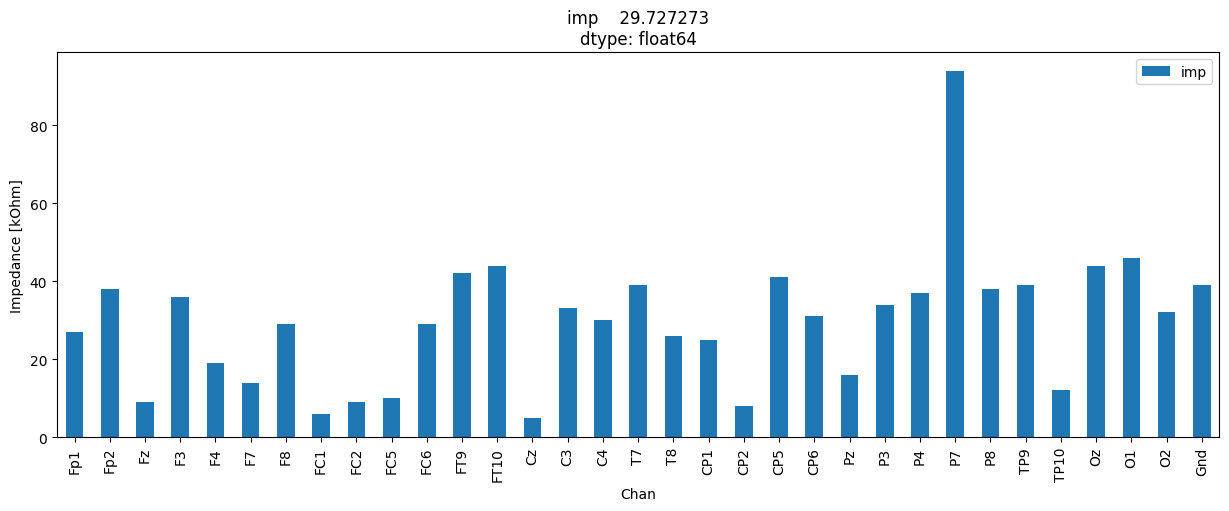

In [10]:
file = data_path / f'raw_data/{participant}/signaux/sub{participants_label[participant]}_{session}.vhdr'
raw = mne.io.read_raw_brainvision(file)
impedances = get_impedances(raw)

if not impedances is None:
    fig,ax = plt.subplots(figsize = (15,5))
    impedances.plot.bar(ax=ax)
    ax.set_title(str(impedances.mean()))
    ax.set_ylabel('Impedance [kOhm]')
    ax.set_xlabel('Chan')
    plt.show()

In [11]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, FT9, FT10, C3, ...
 chs: 31 EEG, 4 misc
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-01-17 14:37:50 UTC
 nchan: 35
 projs: []
 sfreq: 1000.0 Hz
>

In [13]:
da = mne_to_xarray(raw)
df_triggs = get_triggs(raw)
if participant == 'P13' and session == 'ses02':
    da_sliced = da_sliced_from_P13()
else:
    da_sliced = epoching(da, df_triggs)

KeyError: ('Free', 1, 'start')

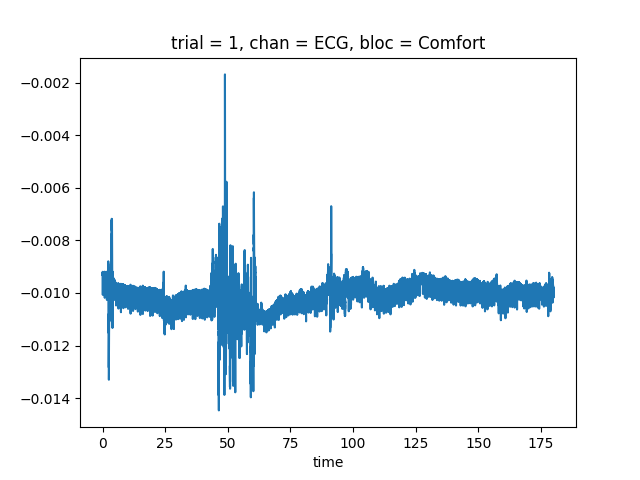

In [59]:
plt.figure()
da_sliced.loc['Comfort',1,'ECG',:].plot()
plt.show()

In [12]:
ecg = da_sliced.loc['Comfort',2,'ECG',:].dropna('time').values * ecg_inversion[participant]
ecg_preproc = gh.filter_sig(ecg, srate , 0.5, 40)
time = gh.time_vector(ecg, srate)

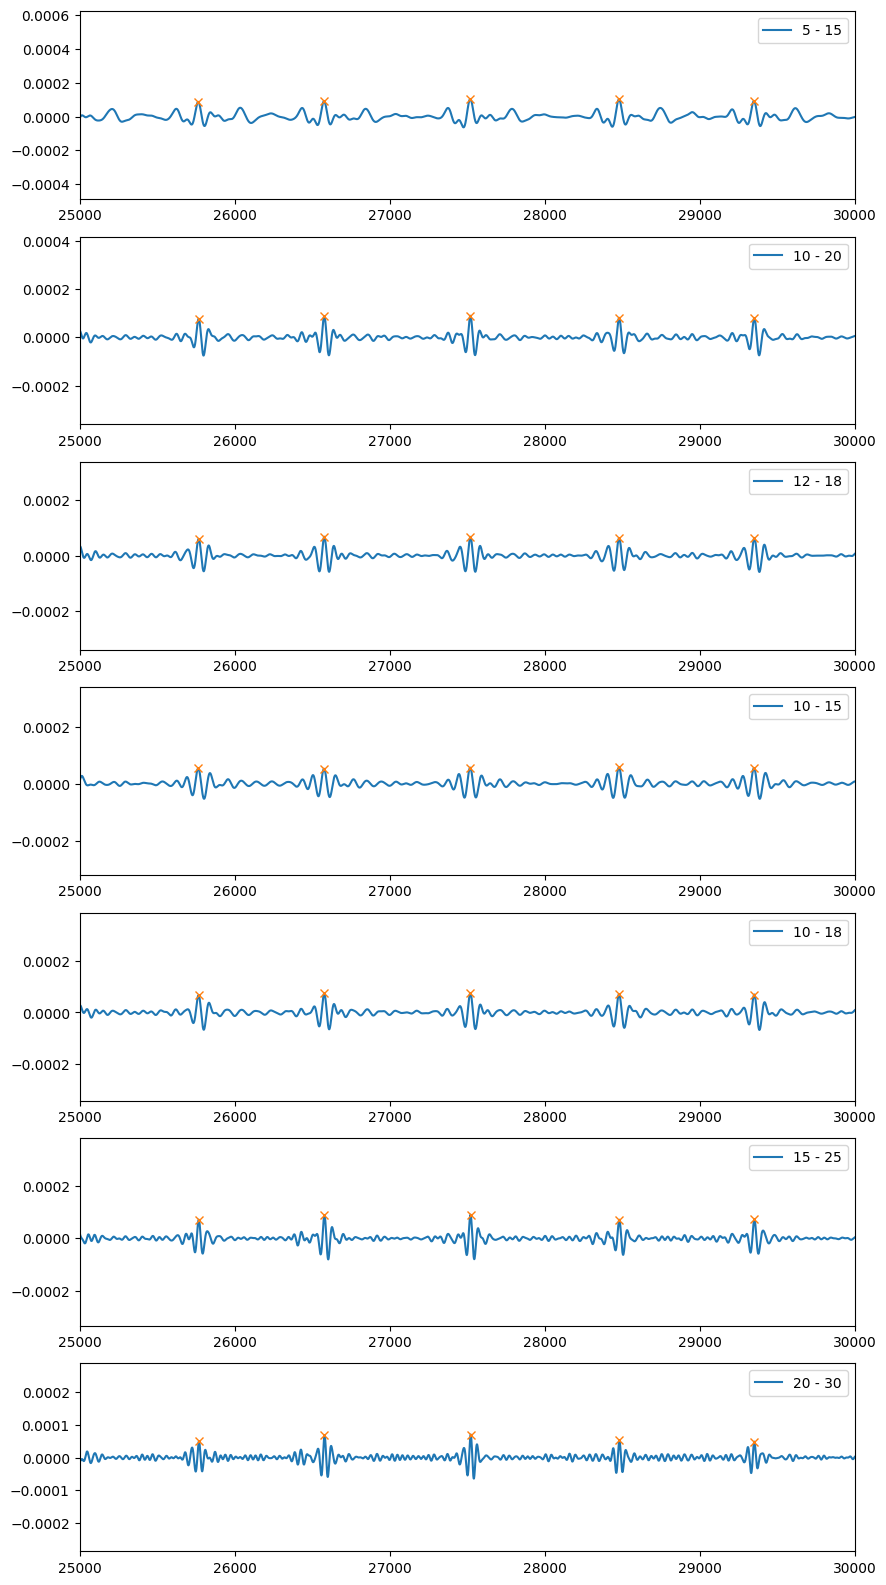

In [13]:
filters = [(5,15),(10,20),(12,18),(10,15),(10,18),(15,25),(20,30)]
fig, axs = plt.subplots(nrows = len(filters), figsize = (10,20))

concat = []
for r, filter_params in enumerate(filters):
    ax = axs[r]
    lowcut = filter_params[0]
    highcut = filter_params[1]
    label = f'{lowcut} - {highcut}'
    ecg_to_compute = gh.filter_sig(ecg, srate, lowcut, highcut)
    peaks = gh.ecg_peaks(ecg_to_compute, srate)
    ax.plot(ecg_to_compute, label = label)
    ax.plot(peaks, ecg_to_compute[peaks], 'x')
    metrics = gh.get_hrv_metrics_homemade(ecg_to_compute, srate)
    metrics.insert(0, 'params', label)
    concat.append(metrics)
    ax.set_xlim(25000,30000)
    ax.legend()
plt.show()

In [14]:
pd.concat(concat)

params      MeanNN        SDNN       RMSSD     pNN50          LF  \
0   5 - 15  854.837321  117.026282  144.344773  0.004785   10.215193   
0  10 - 20  863.096618  156.814517  223.139623  0.004831  105.235842   
0  12 - 18  867.286408  100.245333  132.487901  0.004854    9.745940   
0  10 - 15  863.091787   91.632570  113.532746  0.004831    8.811953   
0  10 - 18  867.286408  105.050707  143.441685  0.004854    8.081677   
0  15 - 25  880.108374  224.534544  338.395150  0.004926   94.693671   
0  20 - 30  859.106280  217.620283  321.496833  0.004831  127.635379   

          HF      LFHF         SD1         SD2              S  
0  40.957478  0.249410  102.056207  127.907027   41009.426678  
0  40.216909  2.616706  157.783289  156.551363   77601.074140  
0  27.126121  0.359282   93.682645  106.782539   31427.458524  
0  21.712523  0.405847   80.279269  102.044073   25736.001198  
0  19.987331  0.404340  101.428184  108.969604   34722.732641  
0  54.434997  1.739573  239.277769  208.444571  156690.552326  
0  53.894180  2.368259  227.330100  207.877808  148461.876435

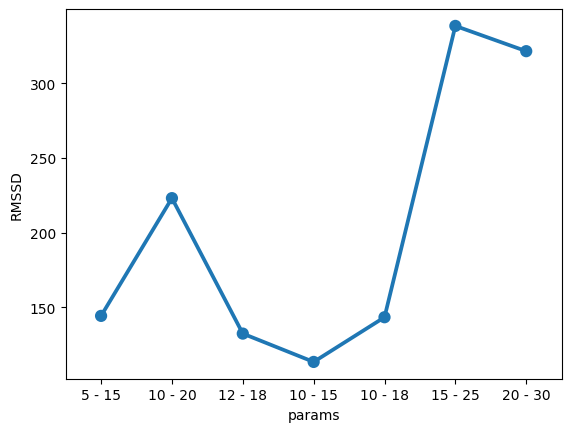

In [15]:
sns.pointplot(data=pd.concat(concat), x = 'params', y = 'RMSSD')
plt.show()

In [16]:
%matplotlib inline

In [17]:
%matplotlib widget

Free 1


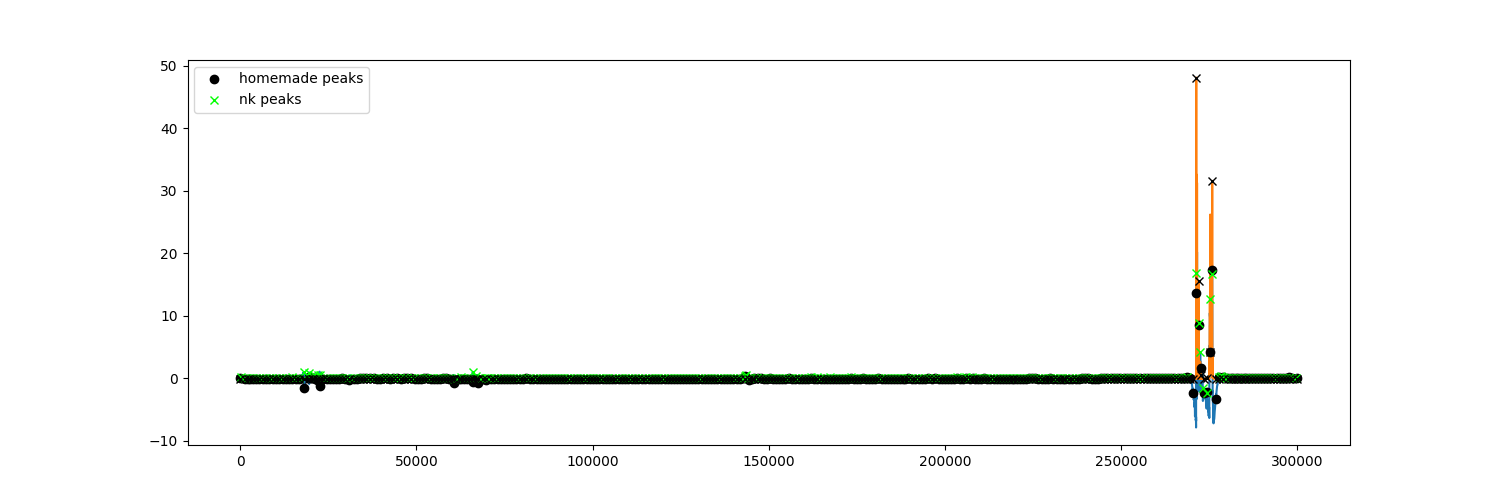

Free 2


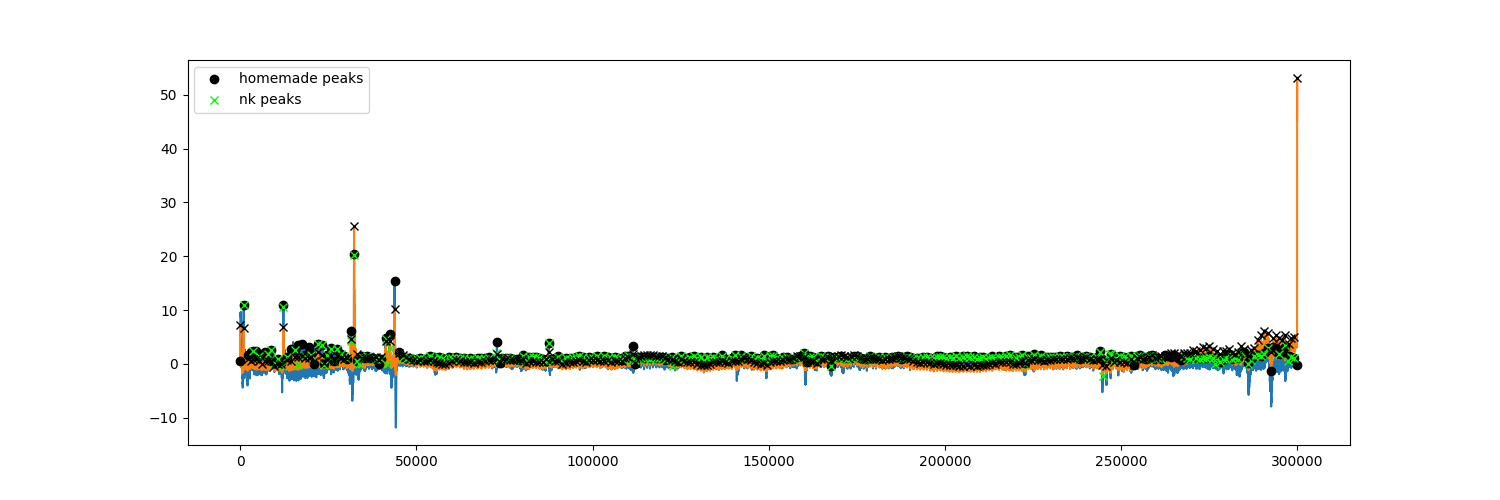

Slow 1


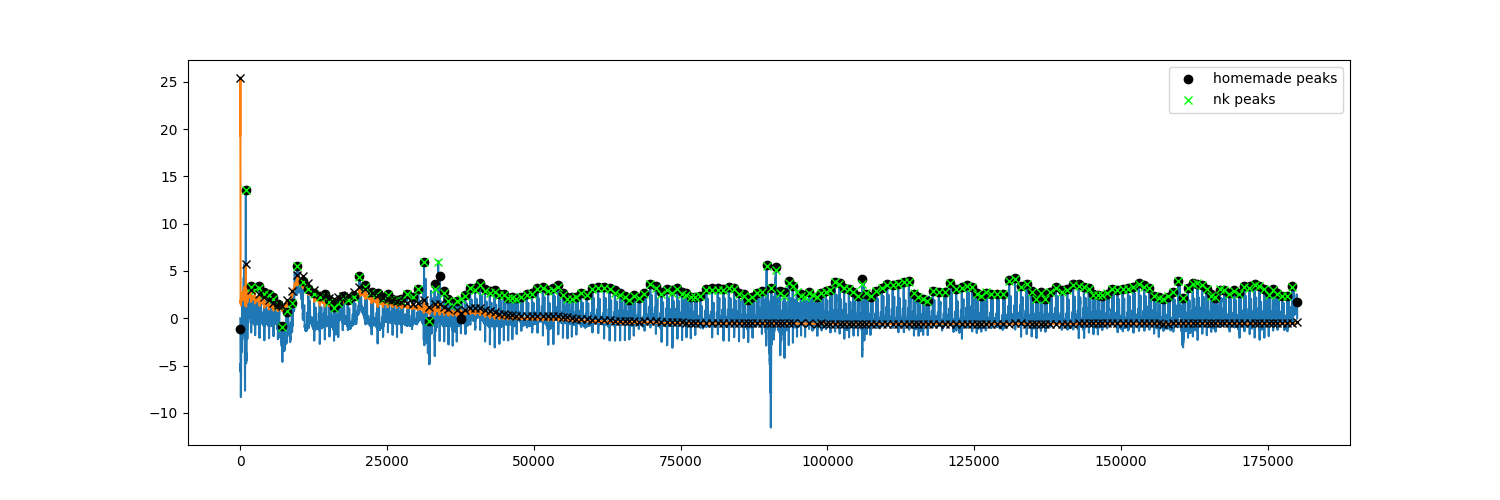

Slow 2


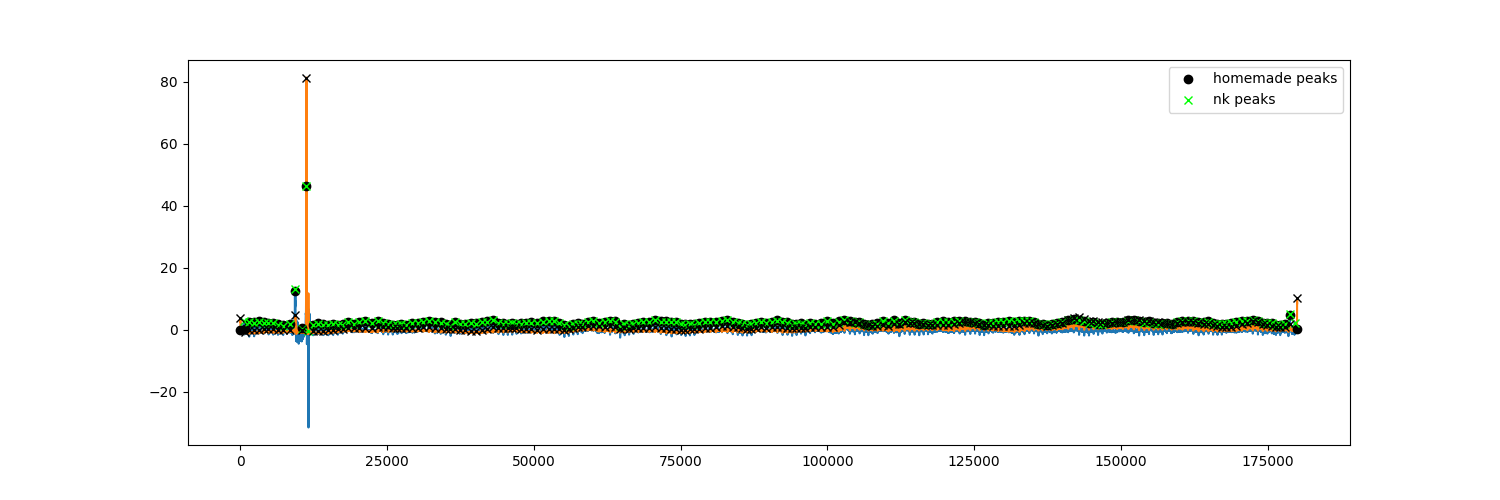

Slow 3


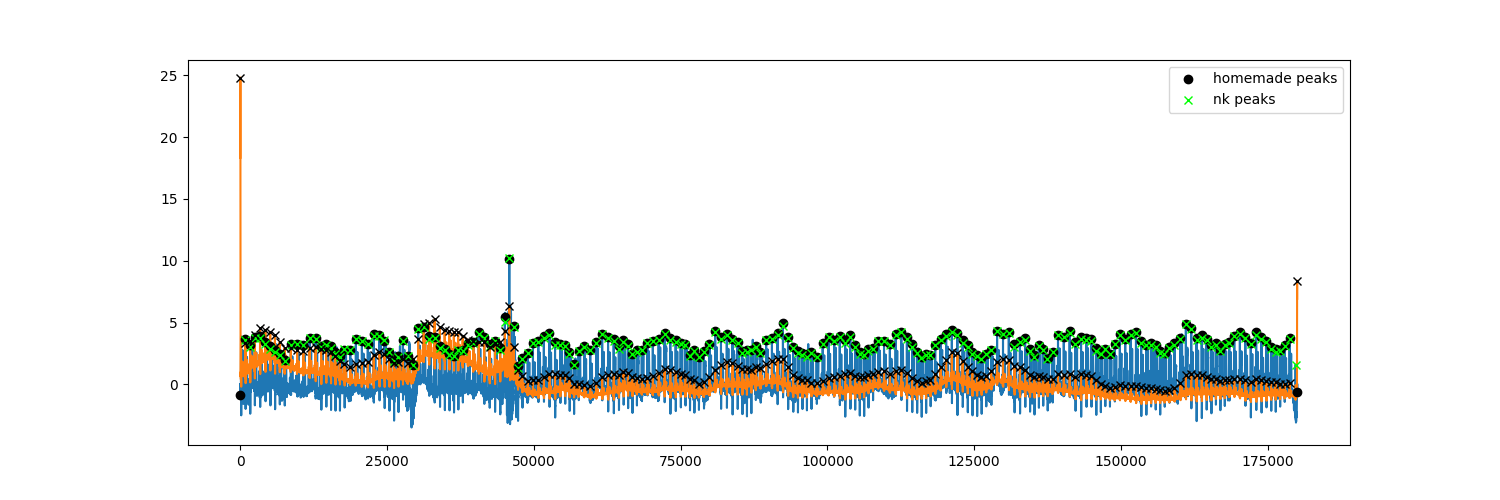

Comfort 1


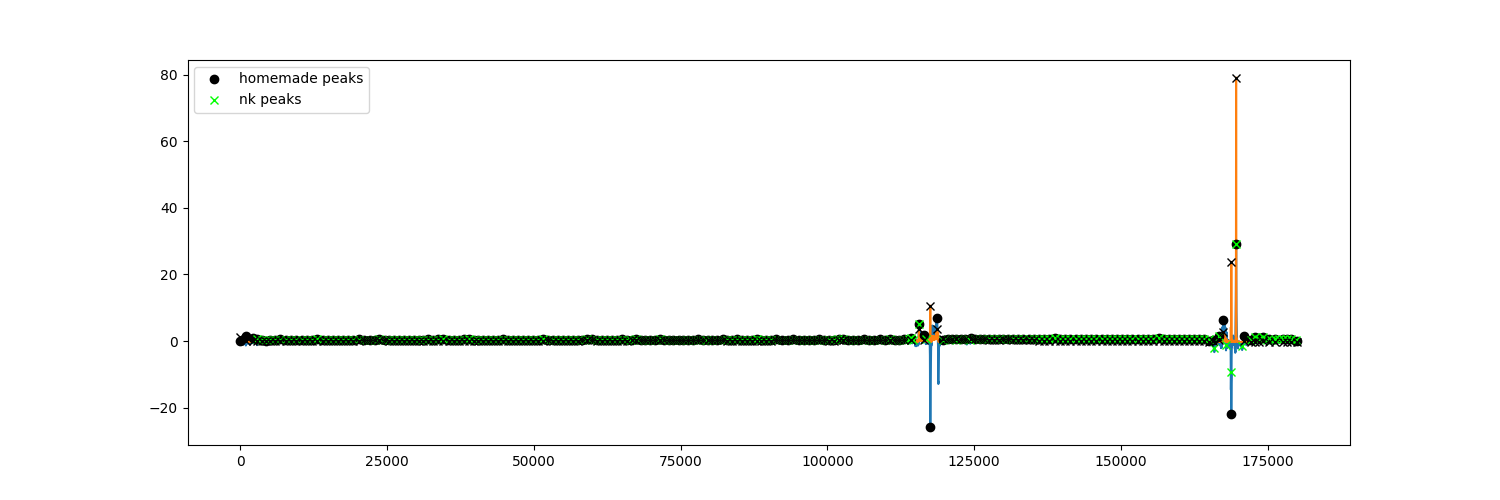

Comfort 2


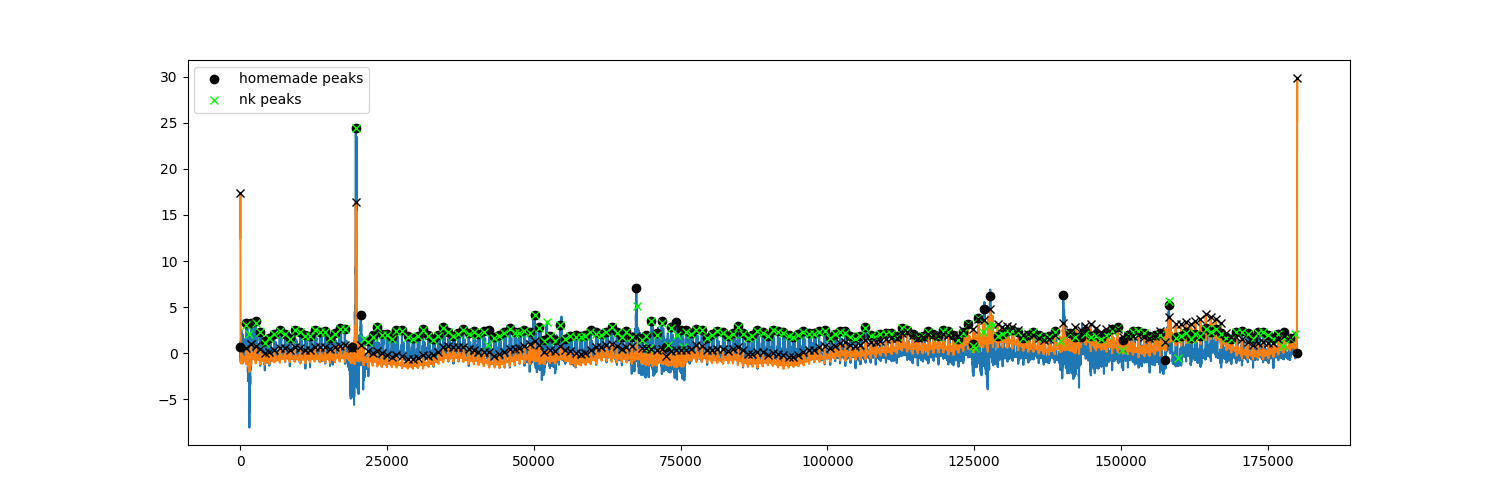

Comfort 3


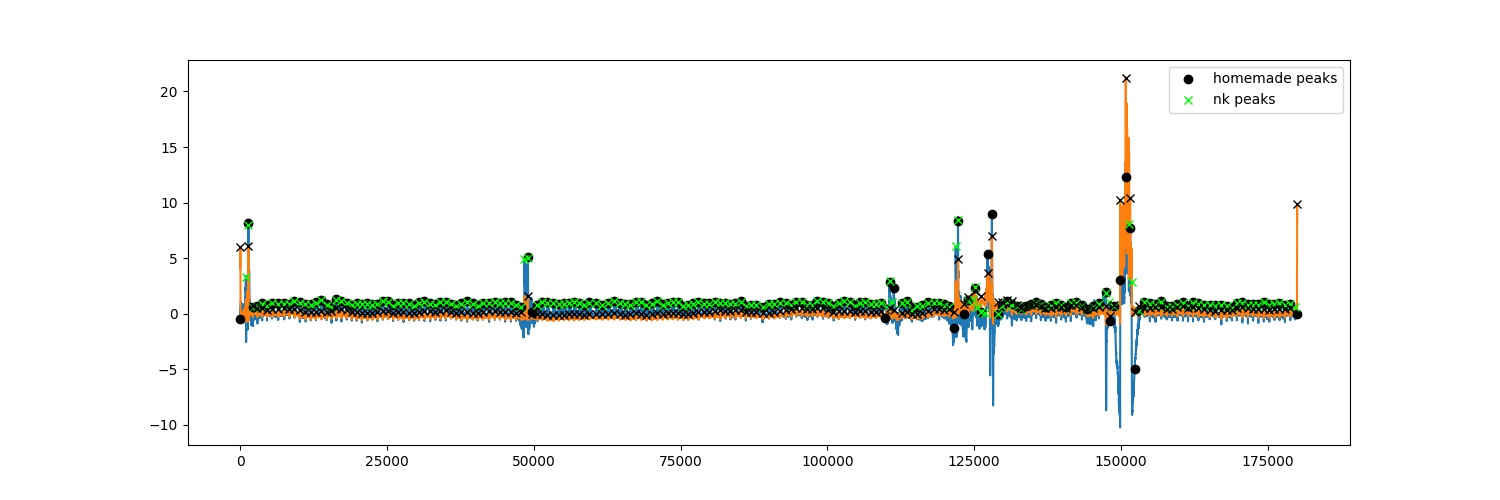

Fast 1


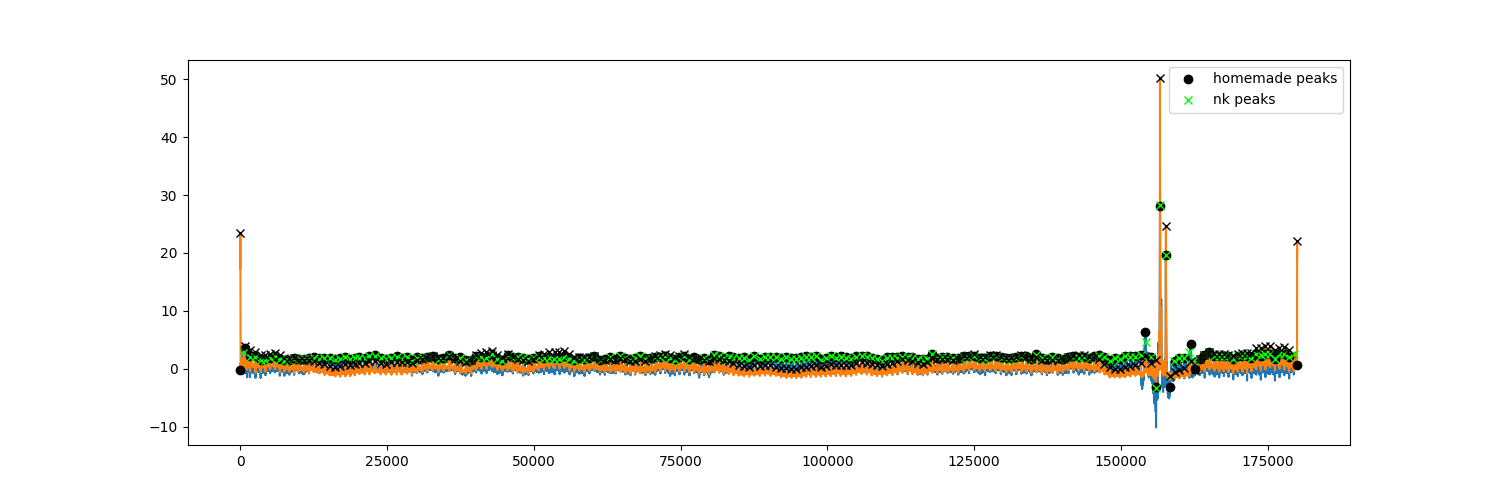

Fast 2


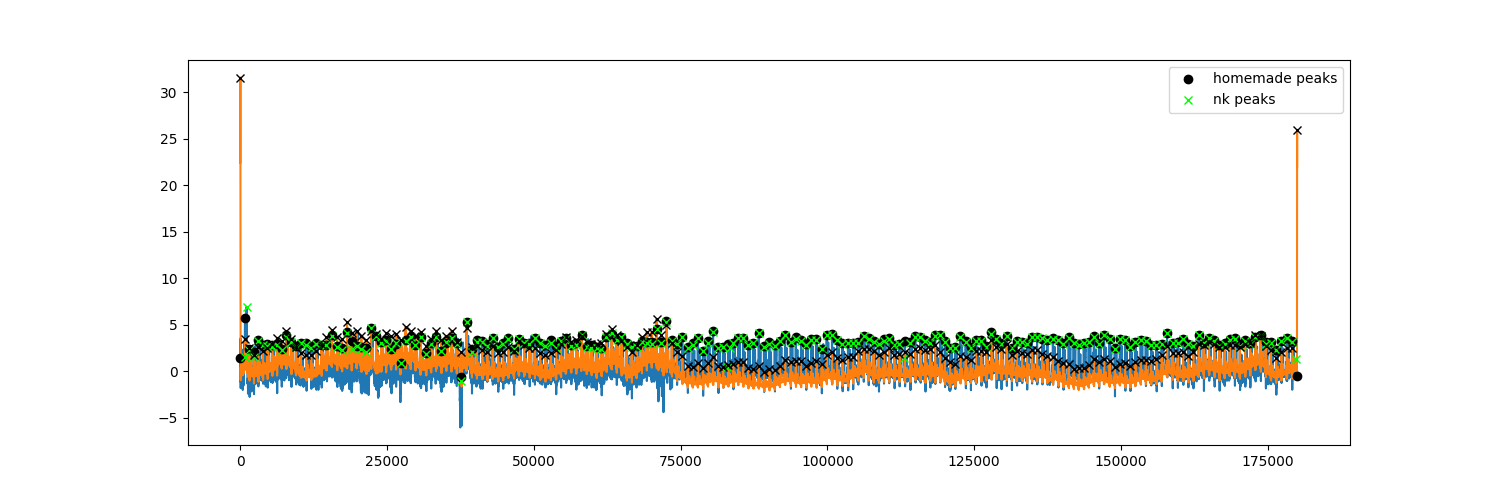

Fast 3


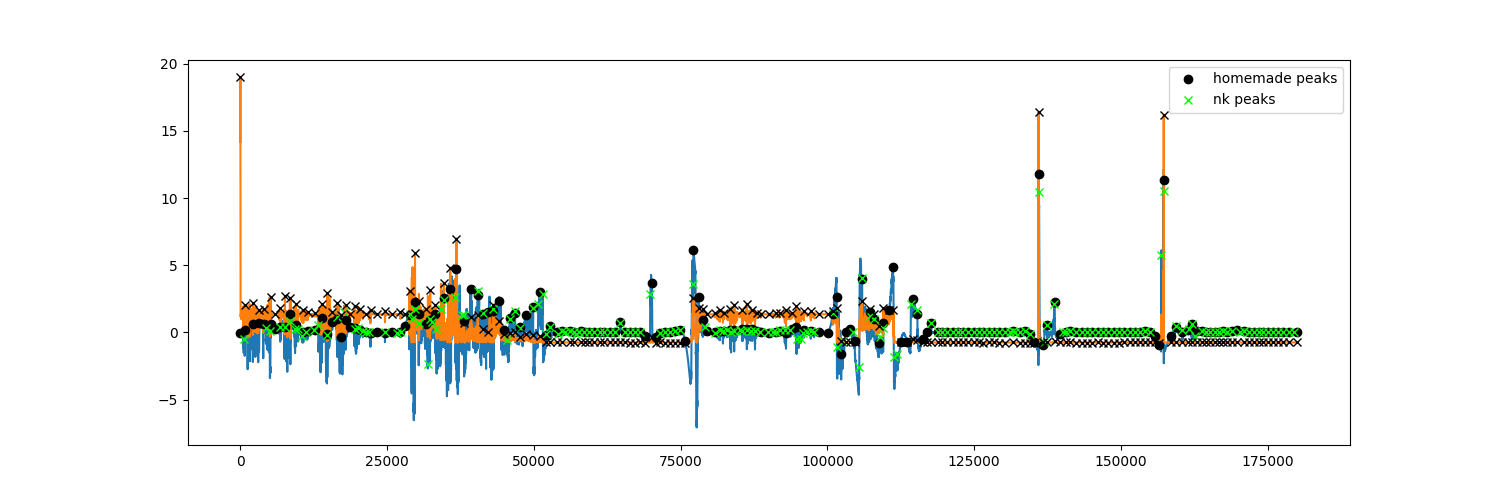

In [18]:
concat = []
for bloc in blocs:
    for trial in count_trials[bloc]:
        ecg = da_sliced.loc[bloc, trial, 'ECG',:].dropna('time').values * ecg_inversion[participant]
        ecg_preproc = gh.filter_sig(ecg, srate, 0.5 , 40)
        print(bloc, trial)
        metrics = gh.hrv_homemade(ecg, srate, mw_freq=18, mw_cycles=2, distance = 700, show = True)
        metrics.insert(0 , 'trial', trial)
        metrics.insert(0, 'bloc', bloc)
        concat.append(metrics)
df_metrics = pd.concat(concat)

NameError: name 'df_metrics' is not defined

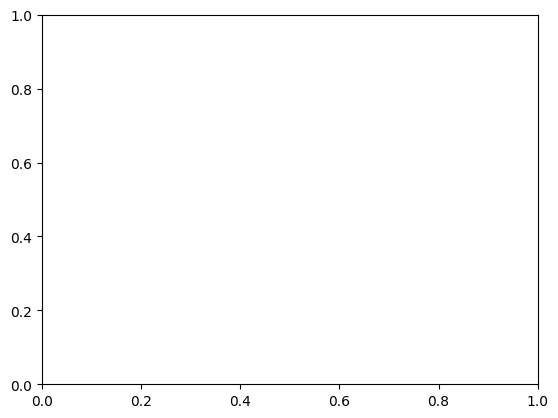

In [12]:
fig, ax = plt.subplots()
sns.boxplot(data=df_metrics, x = 'bloc', y = 'RMSSD', ax=ax)
plt.show()

In [20]:
test = gh.get_qrs_kernel(1000)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


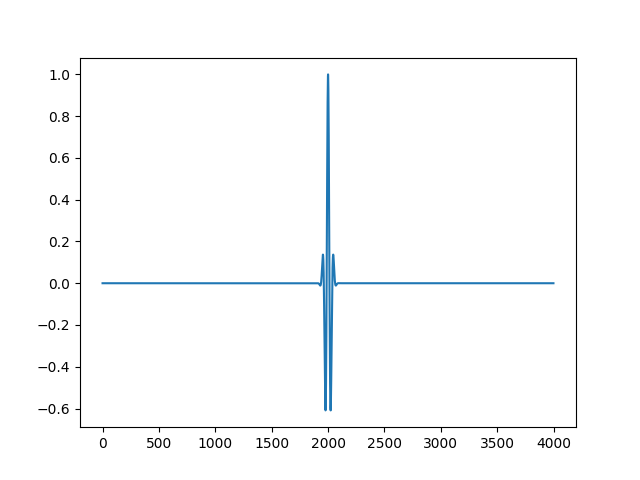

In [21]:
fig, ax = plt.subplots()
ax.plot(test)

In [13]:
ecg = -da.sel(chan = 'ECG').data

In [14]:
ecg_filt = gh.iirfilt(ecg , srate, 5 , 45, order = 10)

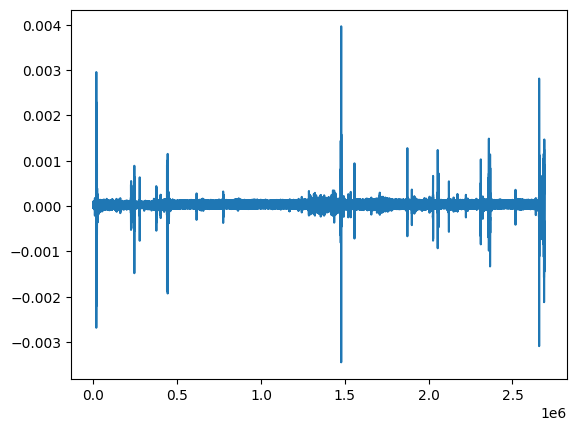

In [16]:
fig, ax = plt.subplots()
ax.plot(ecg_filt)

In [17]:
triggs = get_triggs(raw)

In [18]:
triggs

timestamp
bloc    trial timing           
Free    1     start      14.732
        2     start    2335.838
        1     stop      314.743
        2     stop     2635.841
Slow    1     start     449.517
        2     start     877.524
        3     start    2130.014
        1     stop      629.412
        2     stop     1057.440
        3     stop     2309.934
Comfort 1     start     662.706
        2     start    1718.197
        3     start    1924.691
        1     stop      842.611
        2     stop     1898.112
        3     stop     2104.596
Fast    1     start    1086.348
        2     start    1297.899
        3     start    1508.328
        1     stop     1266.255
        2     stop     1477.810
        3     stop     1688.234

In [19]:
ecg_filt = ecg_filt ** 3

In [20]:
peaks = gh.ecg_peaks(ecg_filt, srate)

In [21]:
%matplotlib widget

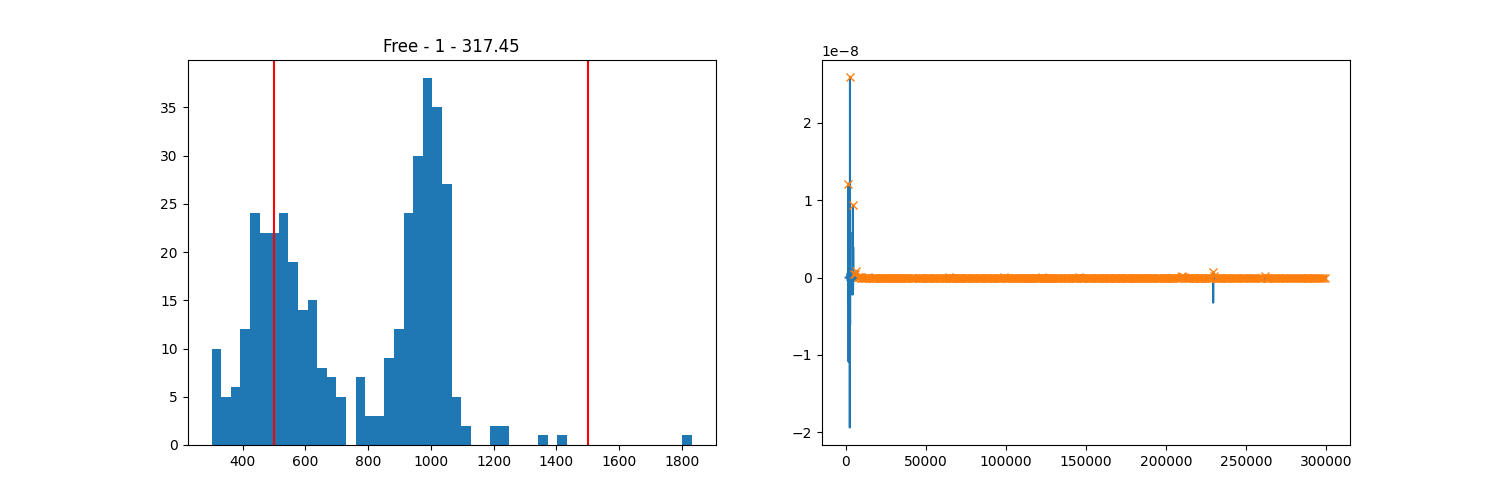

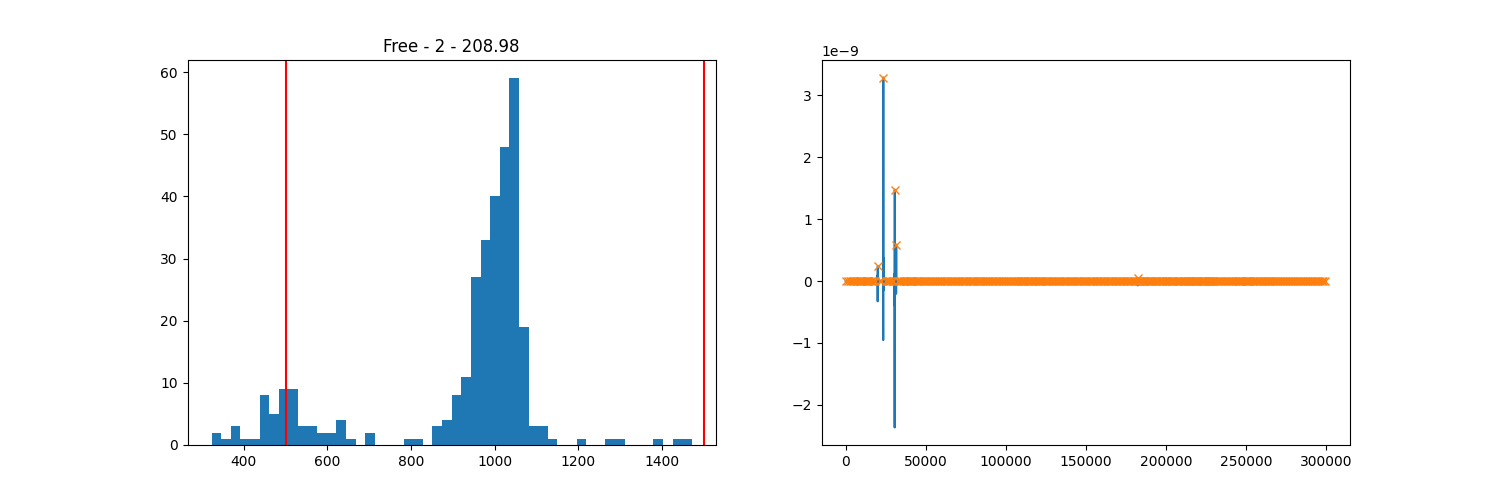

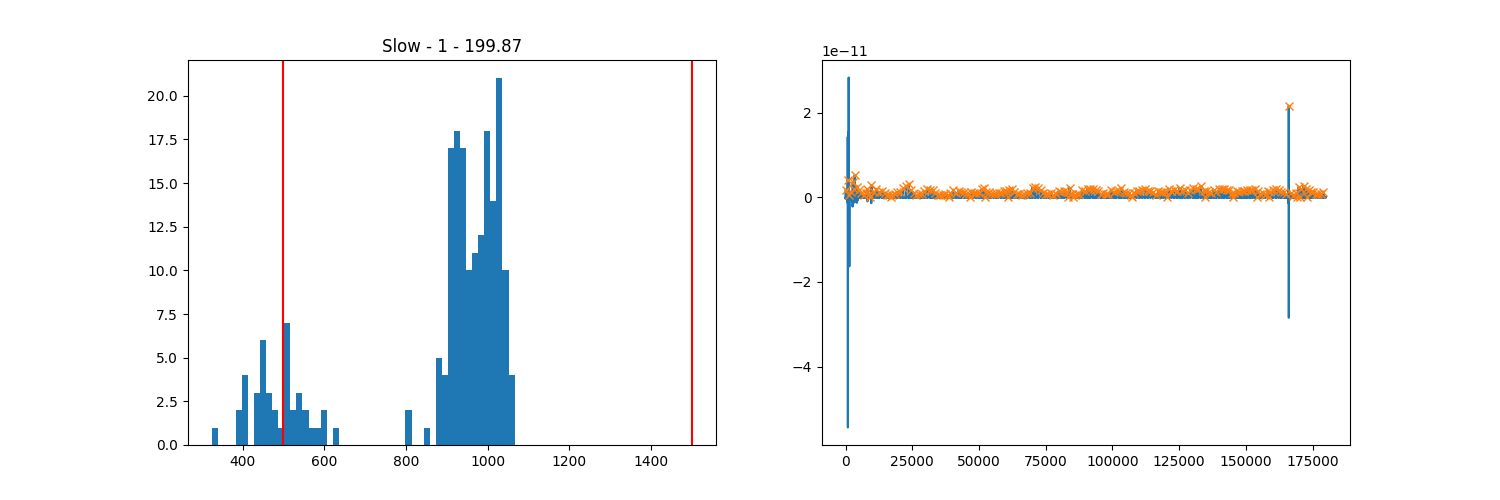

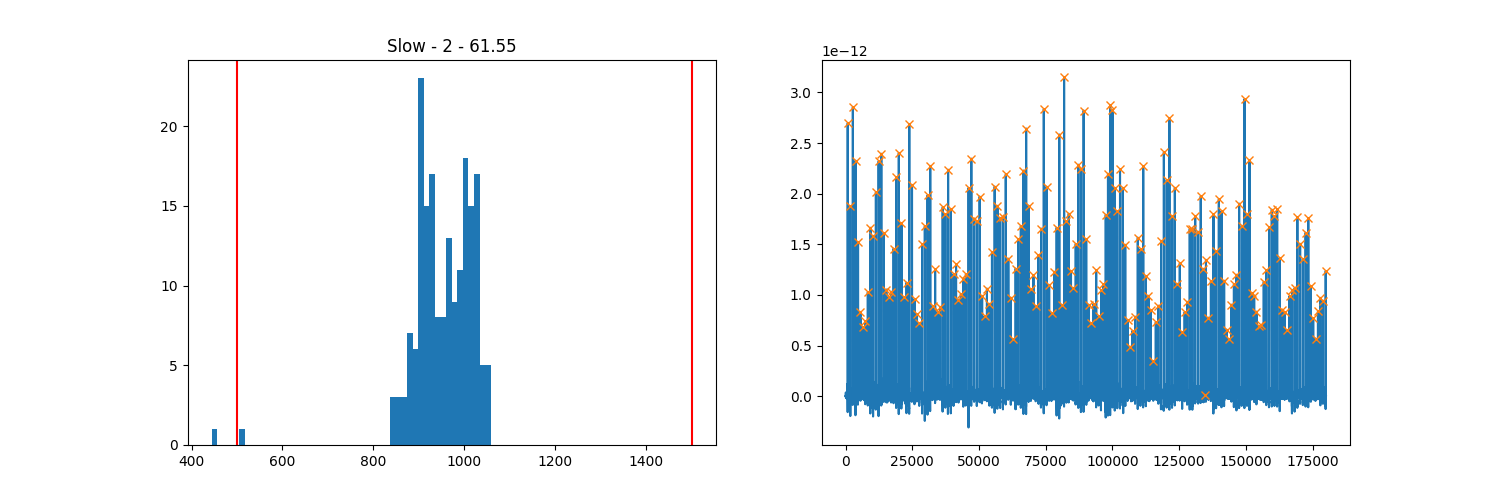

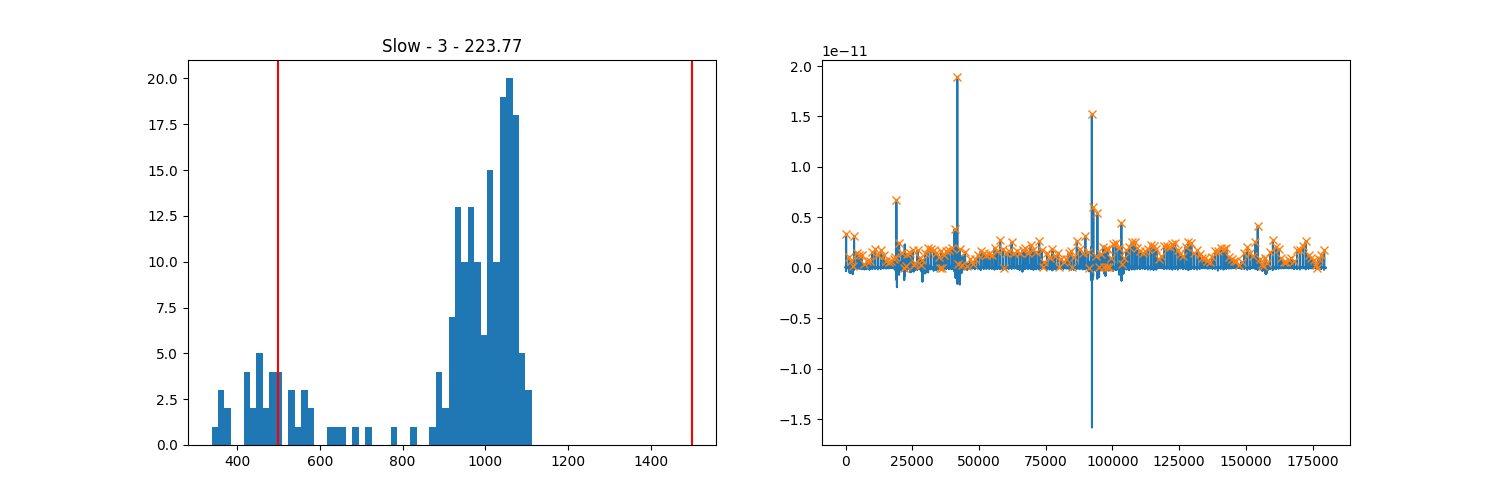

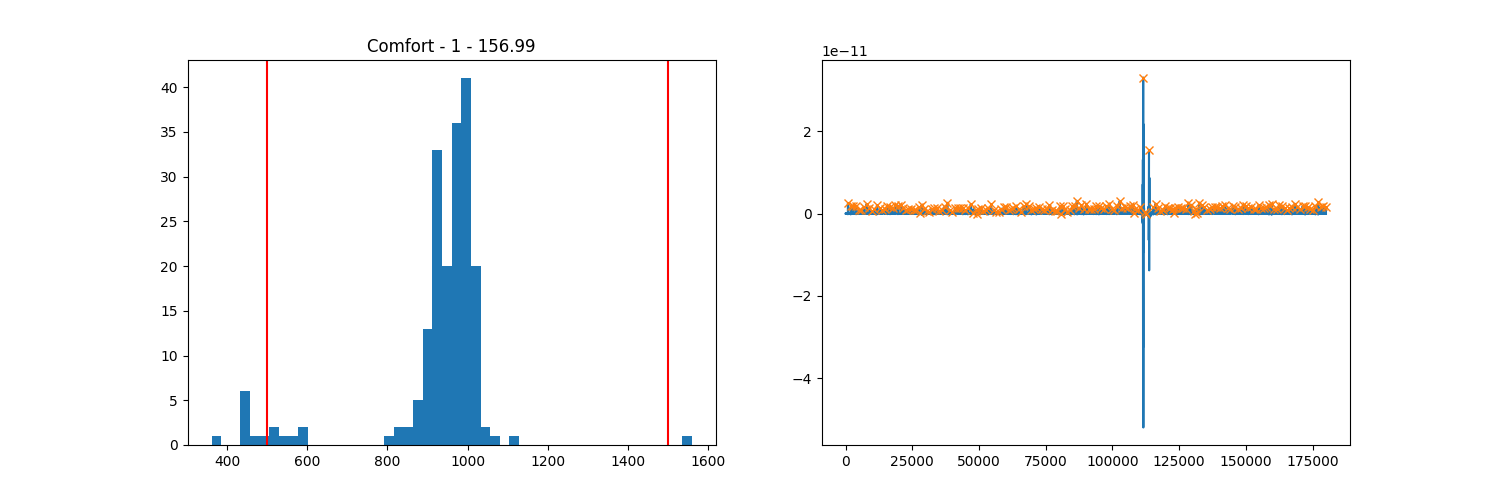

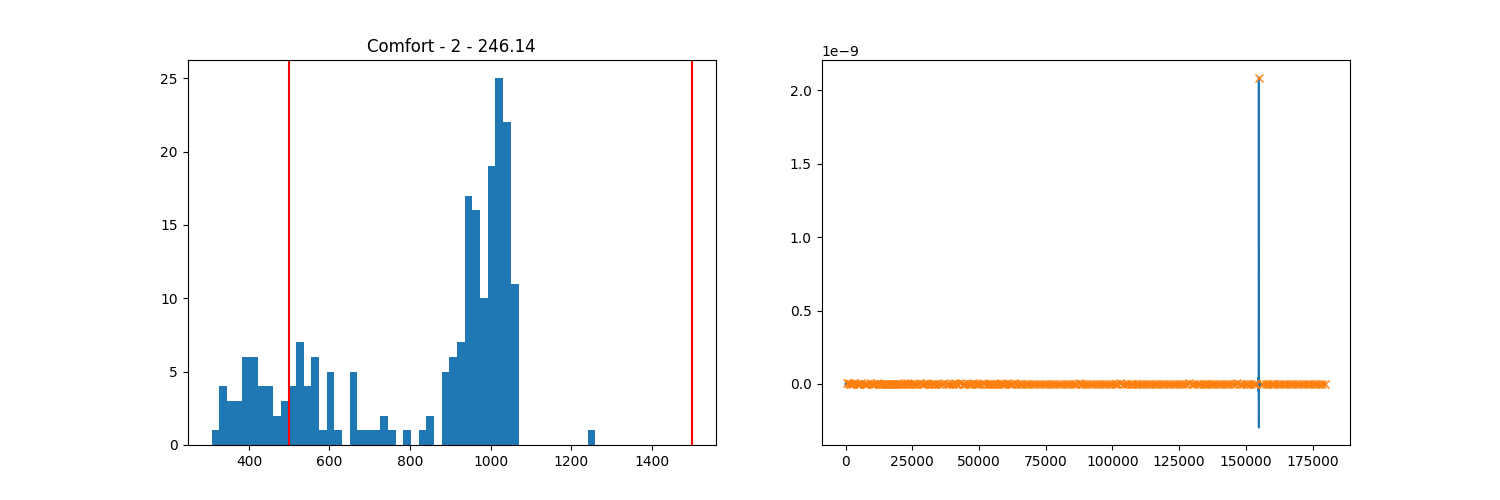

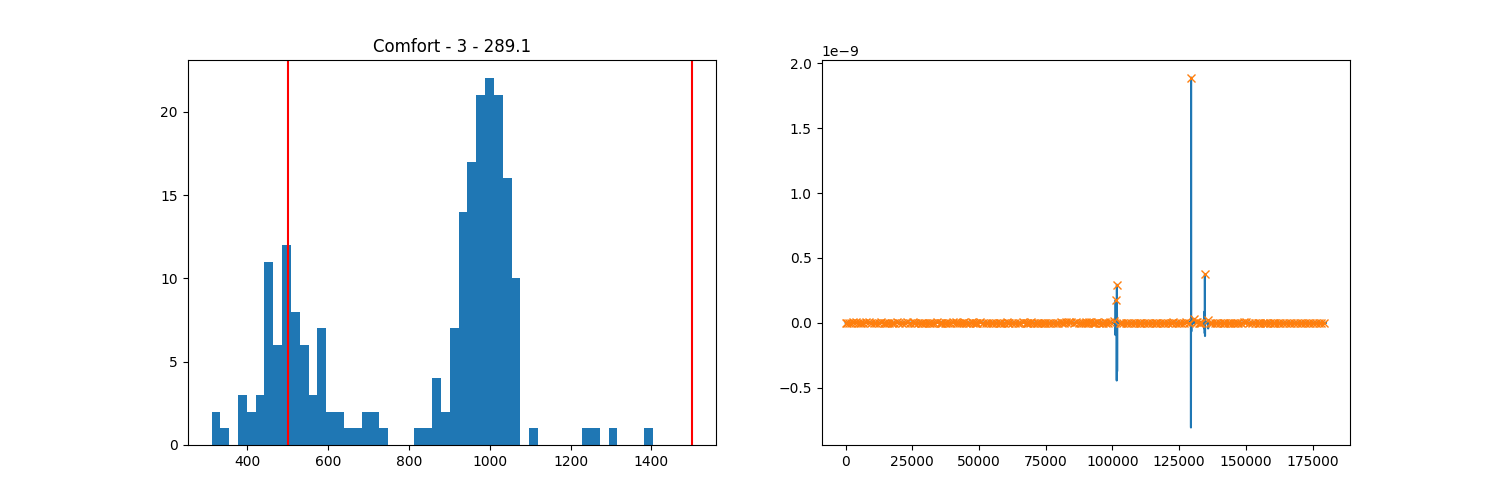

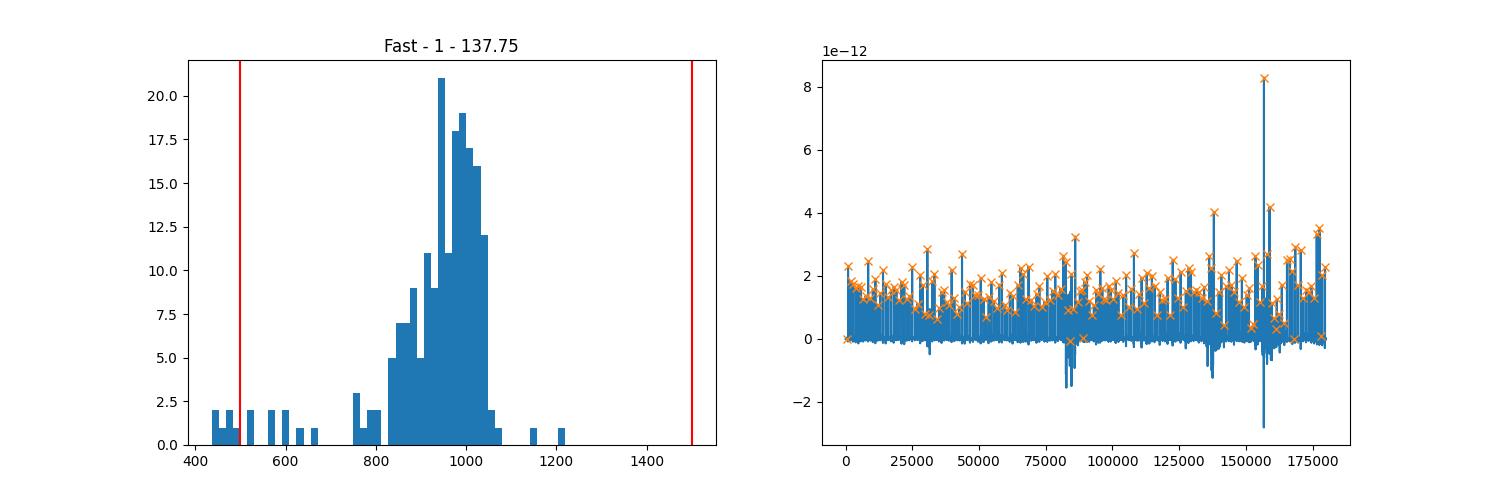

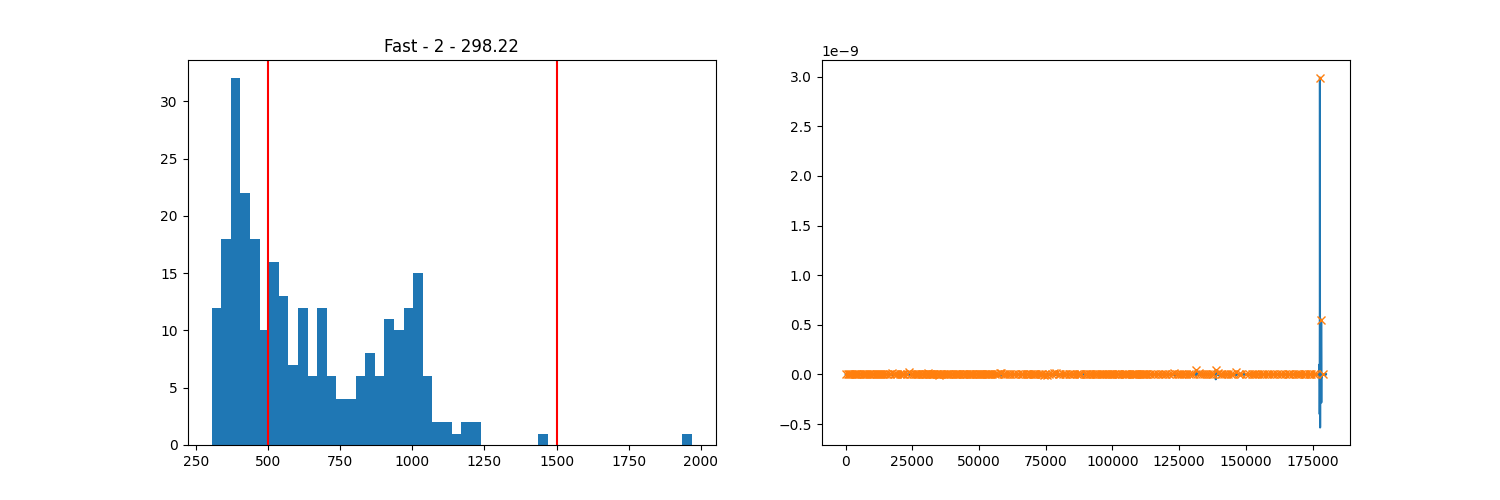

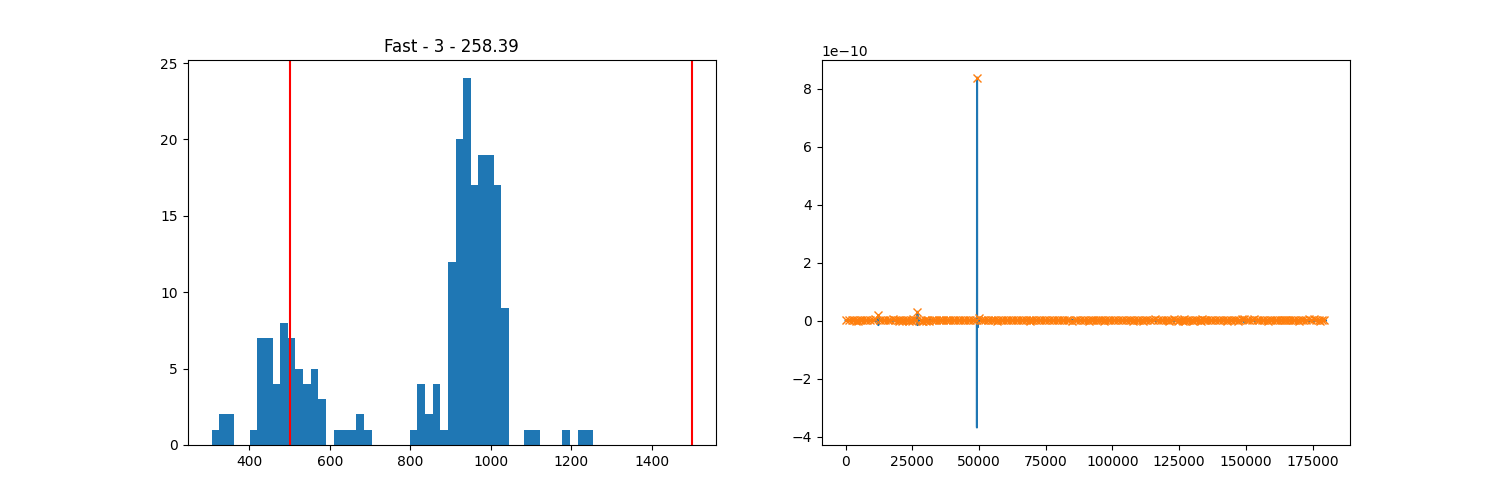

In [30]:
rows = []

for bloc in blocs:
    for trial in count_trials[bloc]:
        start = triggs.loc[(bloc,trial,'start'),'timestamp']
        stop = start + trial_durations[bloc]
        start_idx = int(start * srate)
        stop_idx = int(stop * srate)
        
        mask_peaks = (peaks >= start_idx) & (peaks < stop_idx)
        peaks_of_the_trial = peaks[mask_peaks]
        rris_of_the_trial = gh.peaks_to_RRI(peaks_of_the_trial, srate)
        rmssd = gh.RMSSD(rris_of_the_trial)
        
        mean_rri = np.mean(rris_of_the_trial)
        sd_rri = np.std(rris_of_the_trial)
        borne_inf = mean_rri - 2 * sd_rri
        borne_sup = mean_rri + 2 * sd_rri
        
        fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
        ax = axs[0]
        ax.hist(rris_of_the_trial, bins = 50)
        ax.set_title(f'{bloc} - {trial} - {round(rmssd, 2 )}')
        for x in [500, 1500]:
            ax.axvline(x, color ='red')
        
        ax = axs[1]
        ax.plot(ecg_filt[start_idx:stop_idx])
        peaks_plot = peaks_of_the_trial - start_idx
        ax.plot(peaks_plot, ecg_filt[start_idx:stop_idx][peaks_plot], 'x')
        plt.show()
        
        rows.append([bloc, trial , rmssd])
        
rmssds = pd.DataFrame(rows, columns = ['bloc','trial','rmssd'])

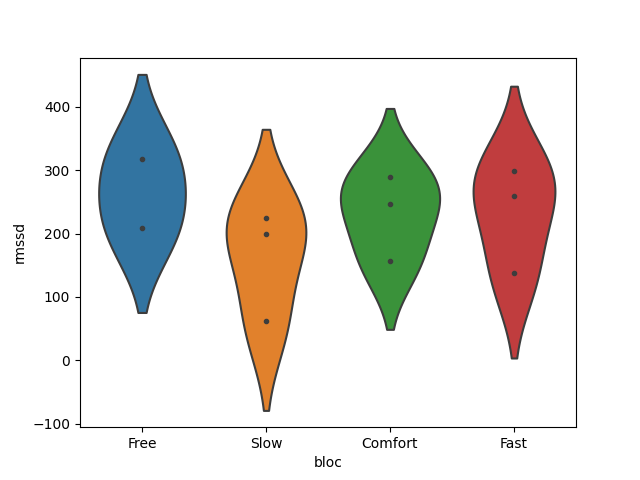

In [23]:
plt.figure()
sns.violinplot(data = rmssds, x = 'bloc', y = 'rmssd', inner = 'point')
plt.show()

In [24]:
rmssds.mean()

/tmp/ipykernel_520010/1195564675.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rmssds.mean()


trial      1.909091
rmssd    218.017742
dtype: float64

In [25]:
rris = gh.peaks_to_RRI(peaks, srate)

In [26]:
rmssds.mean()

/tmp/ipykernel_520010/1195564675.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rmssds.mean()


trial      1.909091
rmssd    218.017742
dtype: float64

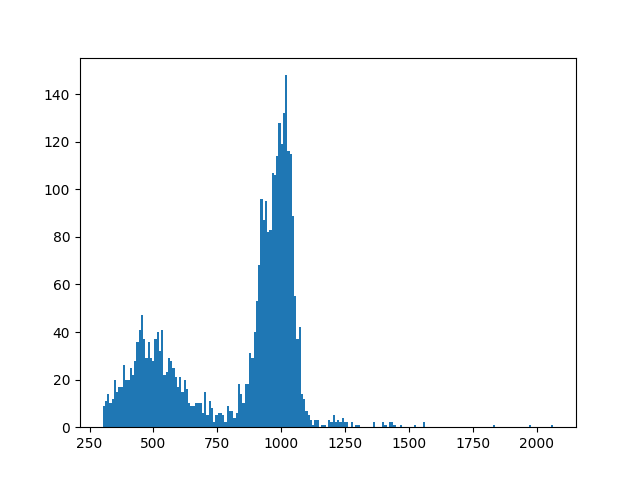

In [27]:
fig, ax = plt.subplots()
ax.hist(rris, bins = 200)
plt.show()

In [28]:
gh.RMSSD(rris)

250.45992968915192

In [8]:
sub = 'P04'
ses = 'ses02'

In [26]:
da = xr.open_dataarray(f'../Preprocessing/Data_Preprocessed/clean_{sub}_{ses}.nc')

In [27]:
%matplotlib widget

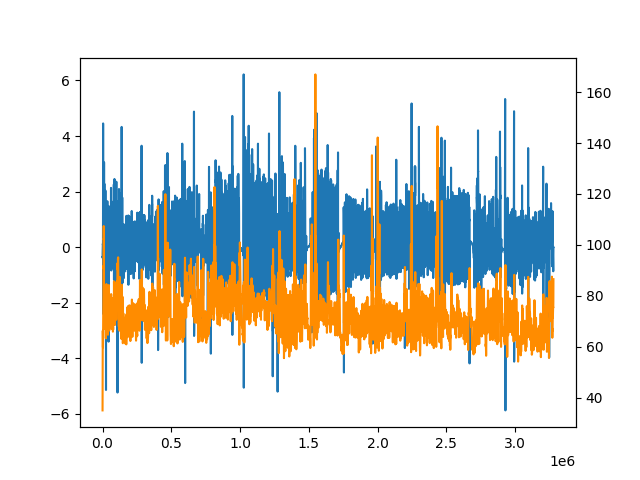

In [30]:
fig, ax = plt.subplots()
ax.plot(gh.norm(da.loc['RespiNasale',:].values))
# ax.plot(gh.norm(da.loc['FCI',:].values))
ax2 = ax.twinx()
ax2.plot(da.loc['FCI',:].values, color = 'darkorange')
# ax.set_xlim(100,130)

In [9]:
da = xr.open_dataarray(f'../Preprocessing/Data_Epoched/{sub}_epoched.nc')

In [10]:
da

<xarray.DataArray (odor: 3, bloc: 4, trial: 3, chan: 36, time: 300000)>
[388800000 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 300.0 300.0 300.0 300.0
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' ... 'RespiVentrale' 'GSR' 'FCI'
  * bloc     (bloc) object 'Free' 'Slow' 'Comfort' 'Fast'
  * odor     (odor) object 'odor_+' 'odor_o' 'odor_-'
  * trial    (trial) int32 1 2 3

In [14]:
power_at_resp = pd.read_excel('../Tables/power_at_resp.xlsx', index_col = 0)

In [15]:
power_at_resp

participant    odor  bloc  trial           chan  f_resp  power_at_resp
0            P01  odor_o  Free      1            Fp1    0.21   3.652311e+01
1            P01  odor_o  Free      1             Fz    0.21   2.038651e+01
2            P01  odor_o  Free      1             F3    0.21   8.108107e+01
3            P01  odor_o  Free      1             F7    0.21   1.180910e+02
4            P01  odor_o  Free      1            FT9    0.21   1.844641e+02
...          ...     ...   ...    ...            ...     ...            ...
3559         P04  odor_-  Fast      3            ECG    0.40   3.632300e-25
3560         P04  odor_-  Fast      3    RespiNasale    0.40   2.287542e+04
3561         P04  odor_-  Fast      3  RespiVentrale    0.40   1.055036e+04
3562         P04  odor_-  Fast      3            GSR    0.40   3.984273e-15
3563         P04  odor_-  Fast      3            FCI    0.40   1.129479e+00

[3564 rows x 7 columns]

In [23]:
power_at_resp[power_at_resp['chan'] == 'FC5'].groupby('odor').mean()

/tmp/ipykernel_738327/3540086612.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  power_at_resp[power_at_resp['chan'] == 'FC5'].groupby('odor').mean()


trial    f_resp  power_at_resp
odor                                     
odor_+  1.909091  0.237576     313.601891
odor_-  1.909091  0.242424     217.776808
odor_o  1.909091  0.236970     285.972035

<AxesSubplot: xlabel='bloc', ylabel='power_at_resp'>

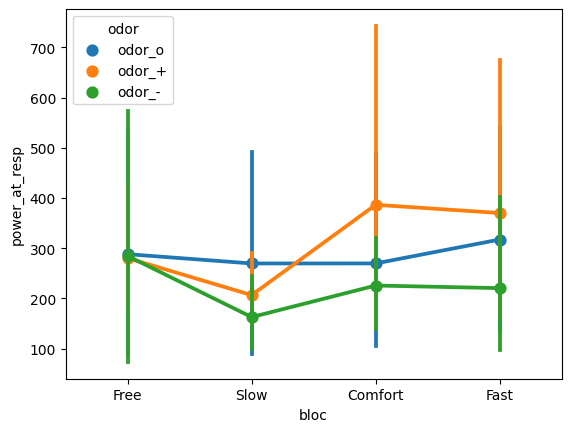

In [24]:
df = power_at_resp[power_at_resp['chan'] == 'FC5']
sns.pointplot(data = df, x = 'bloc', y = 'power_at_resp', hue = 'odor')

<AxesSubplot: xlabel='bloc', ylabel='power_at_resp'>

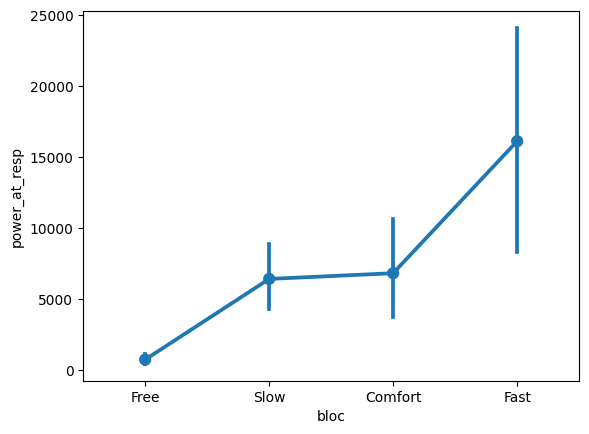

In [18]:
df = power_at_resp[power_at_resp['chan'] == 'RespiNasale']
sns.pointplot(data = df, x = 'bloc', y = 'power_at_resp')

<AxesSubplot: xlabel='bloc', ylabel='f_resp'>

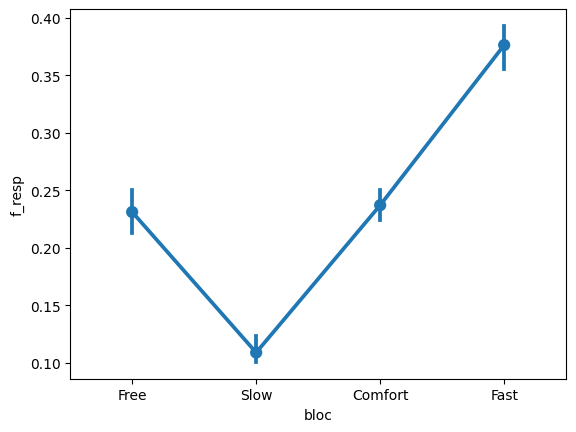

In [20]:
df = power_at_resp[power_at_resp['chan'] == 'RespiNasale']
sns.pointplot(data = df, x = 'bloc', y = 'f_resp')

In [66]:
participant = 'P01'

In [67]:
data = xr.open_dataarray(f'../Preprocessing/Data_Epoched/{participant}_epoched.nc')

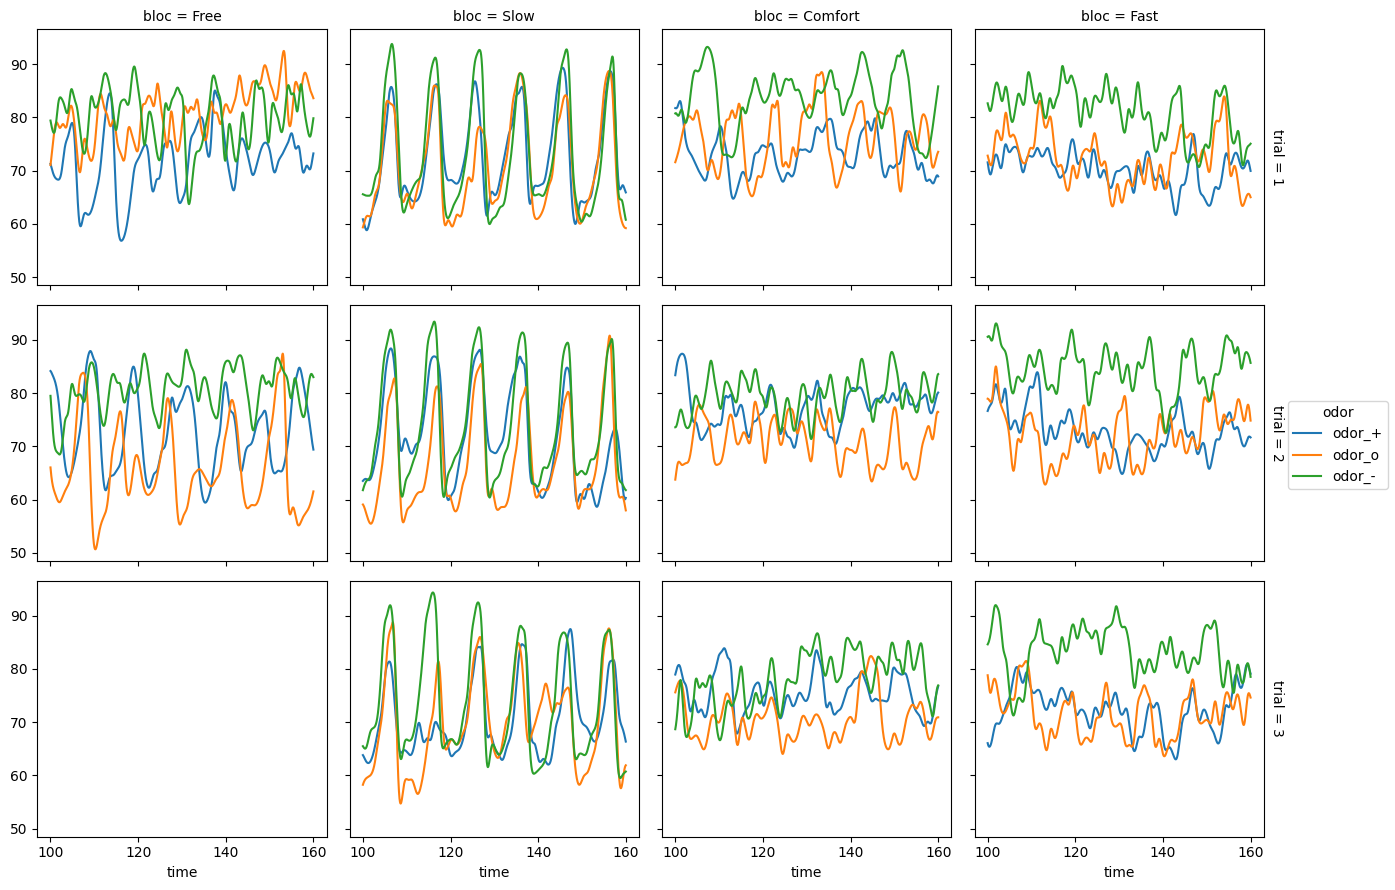

In [52]:
data.sel(chan = 'FCI', time=slice(100,160)).plot.line(x='time', hue = 'odor', col = 'bloc', row = 'trial')

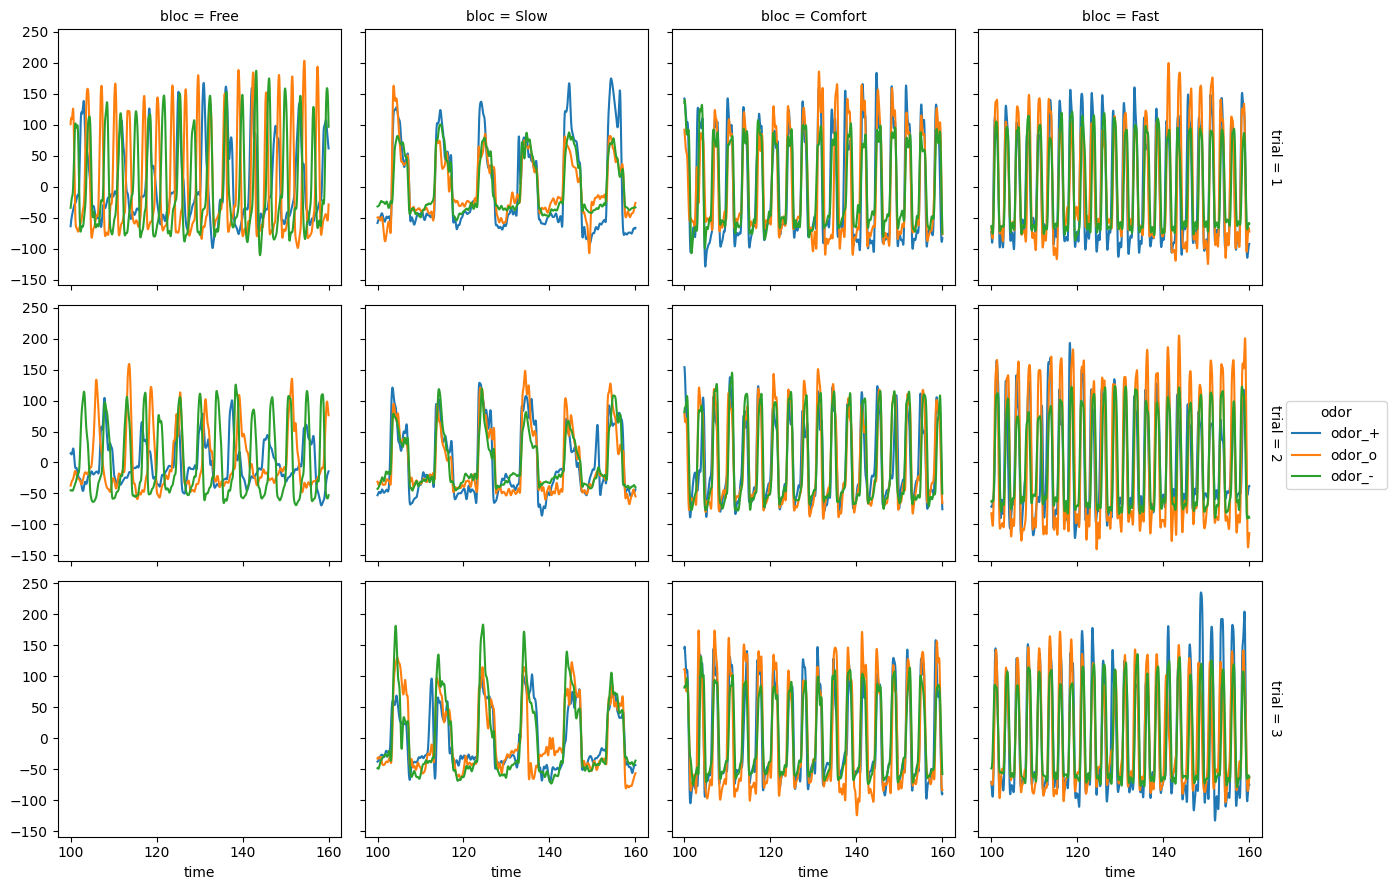

In [53]:
data.sel(chan = 'RespiNasale', time = slice(100,160)).plot.line(x='time', hue = 'odor', col = 'bloc', row = 'trial')

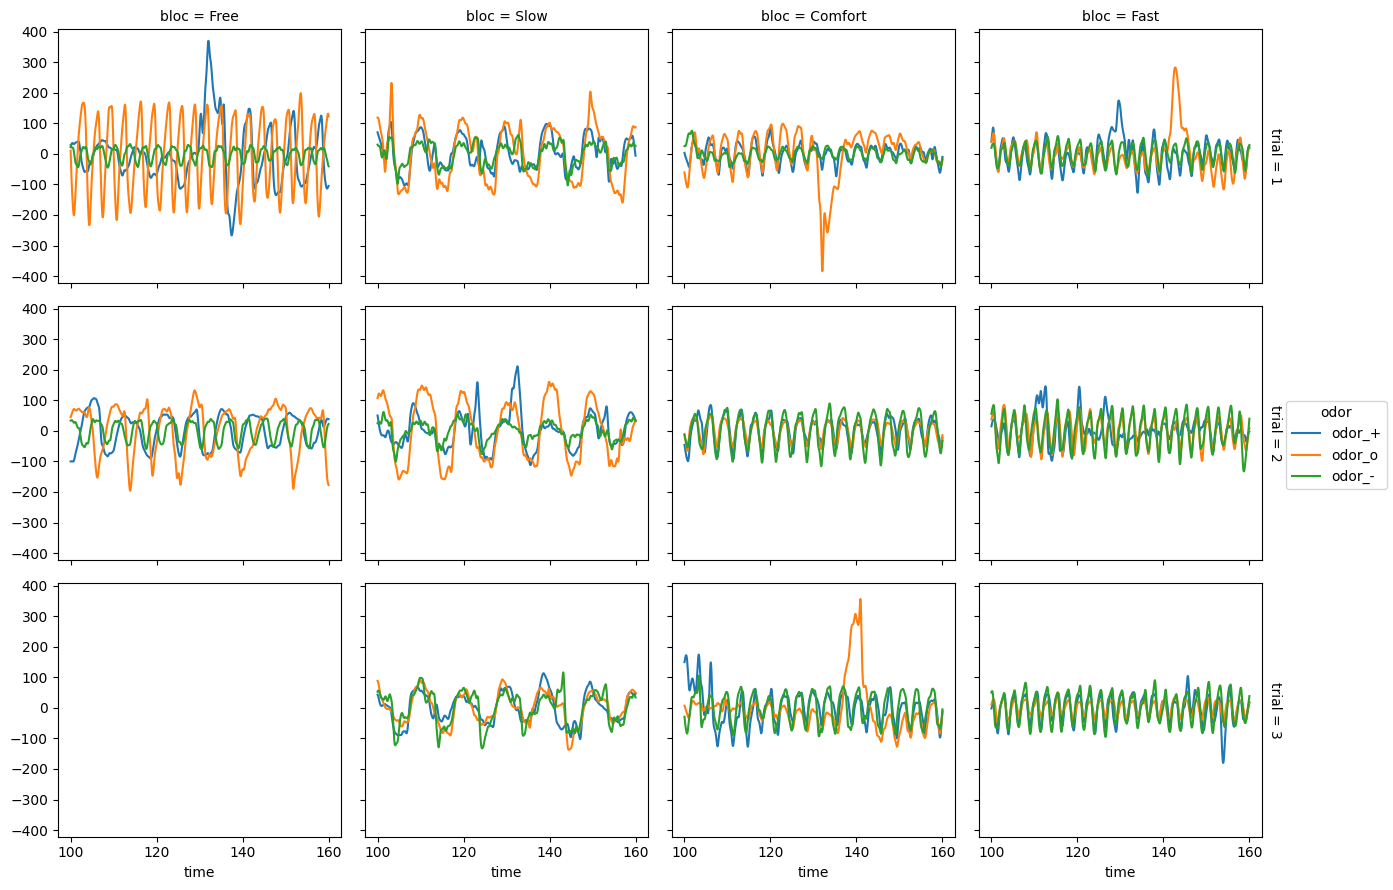

In [54]:
data.sel(chan = 'RespiVentrale', time = slice(100,160)).plot.line(x='time', hue = 'odor', col = 'bloc', row = 'trial')

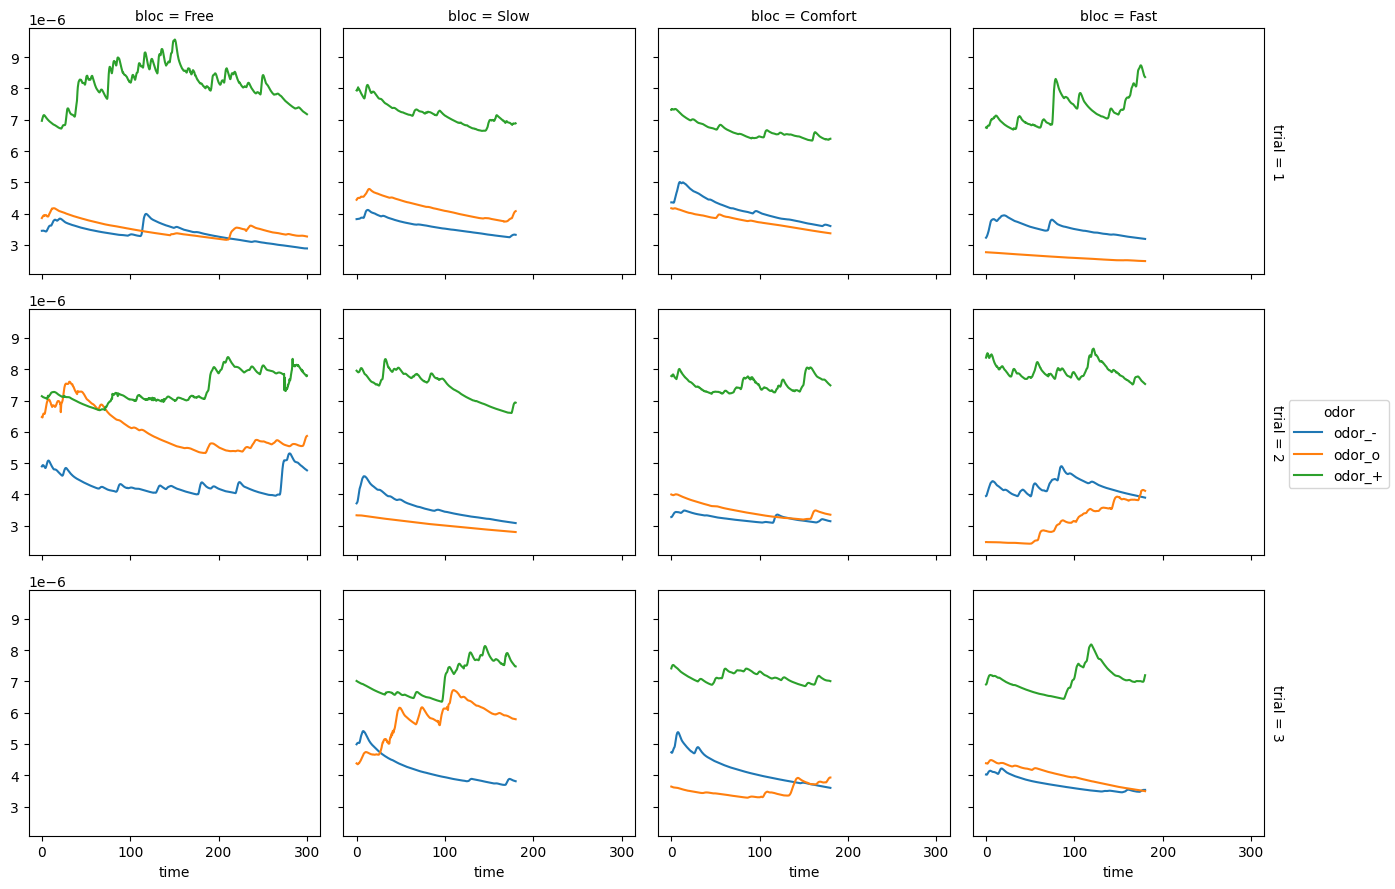

In [58]:
data.sel(chan = 'GSR').plot.line(x='time', hue = 'odor', col = 'bloc', row = 'trial')

In [4]:
coherences = xr.open_dataarray(f'../Analyses/Coherence/{participant}_coherences.nc')

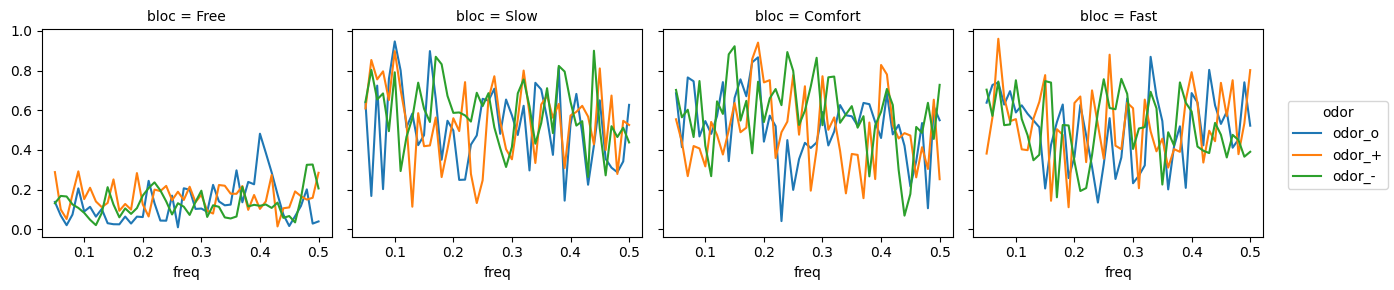

In [14]:
coherences.sel(seed = 'FCI', chan = 'Fp2', freq = slice(0.05,0.5)).mean('trial').plot.line(x = 'freq', col = 'bloc', hue = 'odor')

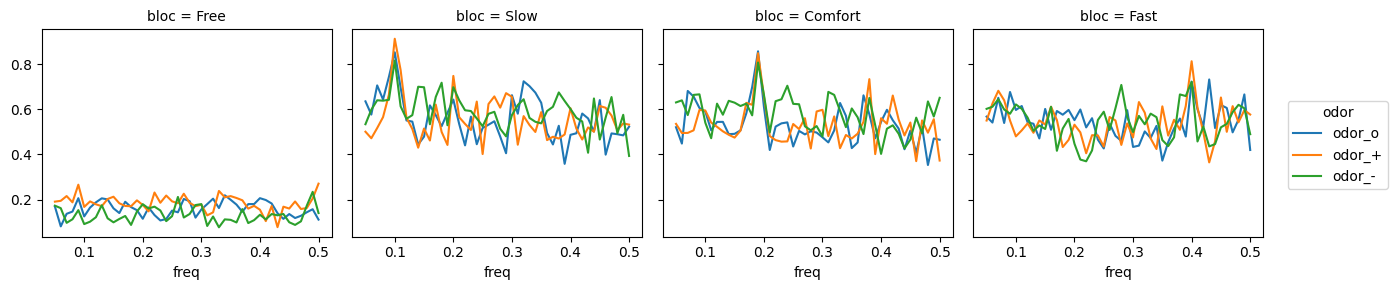

In [15]:
coherences.sel(seed = 'FCI', freq = slice(0.05,0.5)).mean(['chan','trial']).plot.line(x = 'freq', col = 'bloc', hue = 'odor')

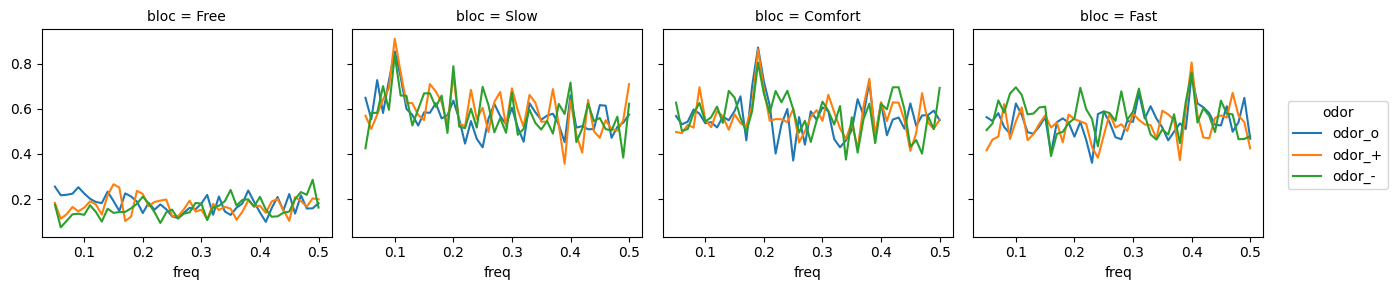

In [16]:
coherences.sel(seed = 'RespiNasale', freq = slice(0.05,0.5)).mean(['chan','trial']).plot.line(x = 'freq', col = 'bloc', hue = 'odor')

In [29]:
# for participant in subject_keys:
#     print(participant)
#     for session in ['ses02','ses03','ses04']:
#         file = data_path + f'{participant}/signaux/sub{participants_label[participant]}_{session}.vhdr'
#         raw = mne.io.read_raw_brainvision(file, preload = False, verbose = 'CRITICAL')
#         triggs = get_triggs(raw)
#         triggs.insert(0, 'session', session)
#         triggs.insert(0, 'participant', participants_label[participant])
#         triggs.reset_index(drop = True).to_excel(data_path + f'{participant}/signaux/sub{participants_label[participant]}_{session}_triggs.xlsx')

In [3]:
participant = 'P23'

In [4]:
data = xr.open_dataarray(f'../Preprocessing/Data_Epoched/{participant}_epoched.nc')

In [6]:
data

<xarray.DataArray (odor: 3, bloc: 4, trial: 3, chan: 36, time: 300000)>
[388800000 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 300.0 300.0 300.0 300.0
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' ... 'RespiVentrale' 'GSR' 'FCI'
  * bloc     (bloc) object 'Free' 'Slow' 'Comfort' 'Fast'
  * odor     (odor) object 'odor_-' 'odor_+' 'odor_o'
  * trial    (trial) int32 1 2 3

In [58]:
metrics.loc[0, 'HRV_Mean']

742.5

660 peaks removed
618 peaks removed
342 peaks removed
333 peaks removed
347 peaks removed
422 peaks removed
377 peaks removed
316 peaks removed
427 peaks removed
424 peaks removed
414 peaks removed
660 peaks removed
615 peaks removed
208 peaks removed


/mnt/autofs/cmo/users/ValentinGhibaudo/physiotools/physio/physio/ecg.py:79: RuntimeWarning: Mean of empty slice
  # TODO
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/autofs/cmo/users/ValentinGhibaudo/physiotools/physio/physio/ecg.py:88: RuntimeWarning: Mean of empty slice
  # compute HRV with resample
/mnt/autofs/cmo/users/ValentinGhibaudo/physiotools/physio/physio/ecg.py:79: RuntimeWarning: Mean of empt

329 peaks removed
344 peaks removed
334 peaks removed
389 peaks removed
327 peaks removed
358 peaks removed
430 peaks removed
421 peaks removed
630 peaks removed
605 peaks removed
235 peaks removed
248 peaks removed
233 peaks removed
363 peaks removed
283 peaks removed
274 peaks removed
458 peaks removed
435 peaks removed
378 peaks removed


/mnt/autofs/cmo/users/ValentinGhibaudo/physiotools/physio/physio/ecg.py:88: RuntimeWarning: Mean of empty slice
  # compute HRV with resample
/mnt/autofs/cmo/users/ValentinGhibaudo/physiotools/physio/physio/ecg.py:88: RuntimeWarning: Mean of empty slice
  # compute HRV with resample


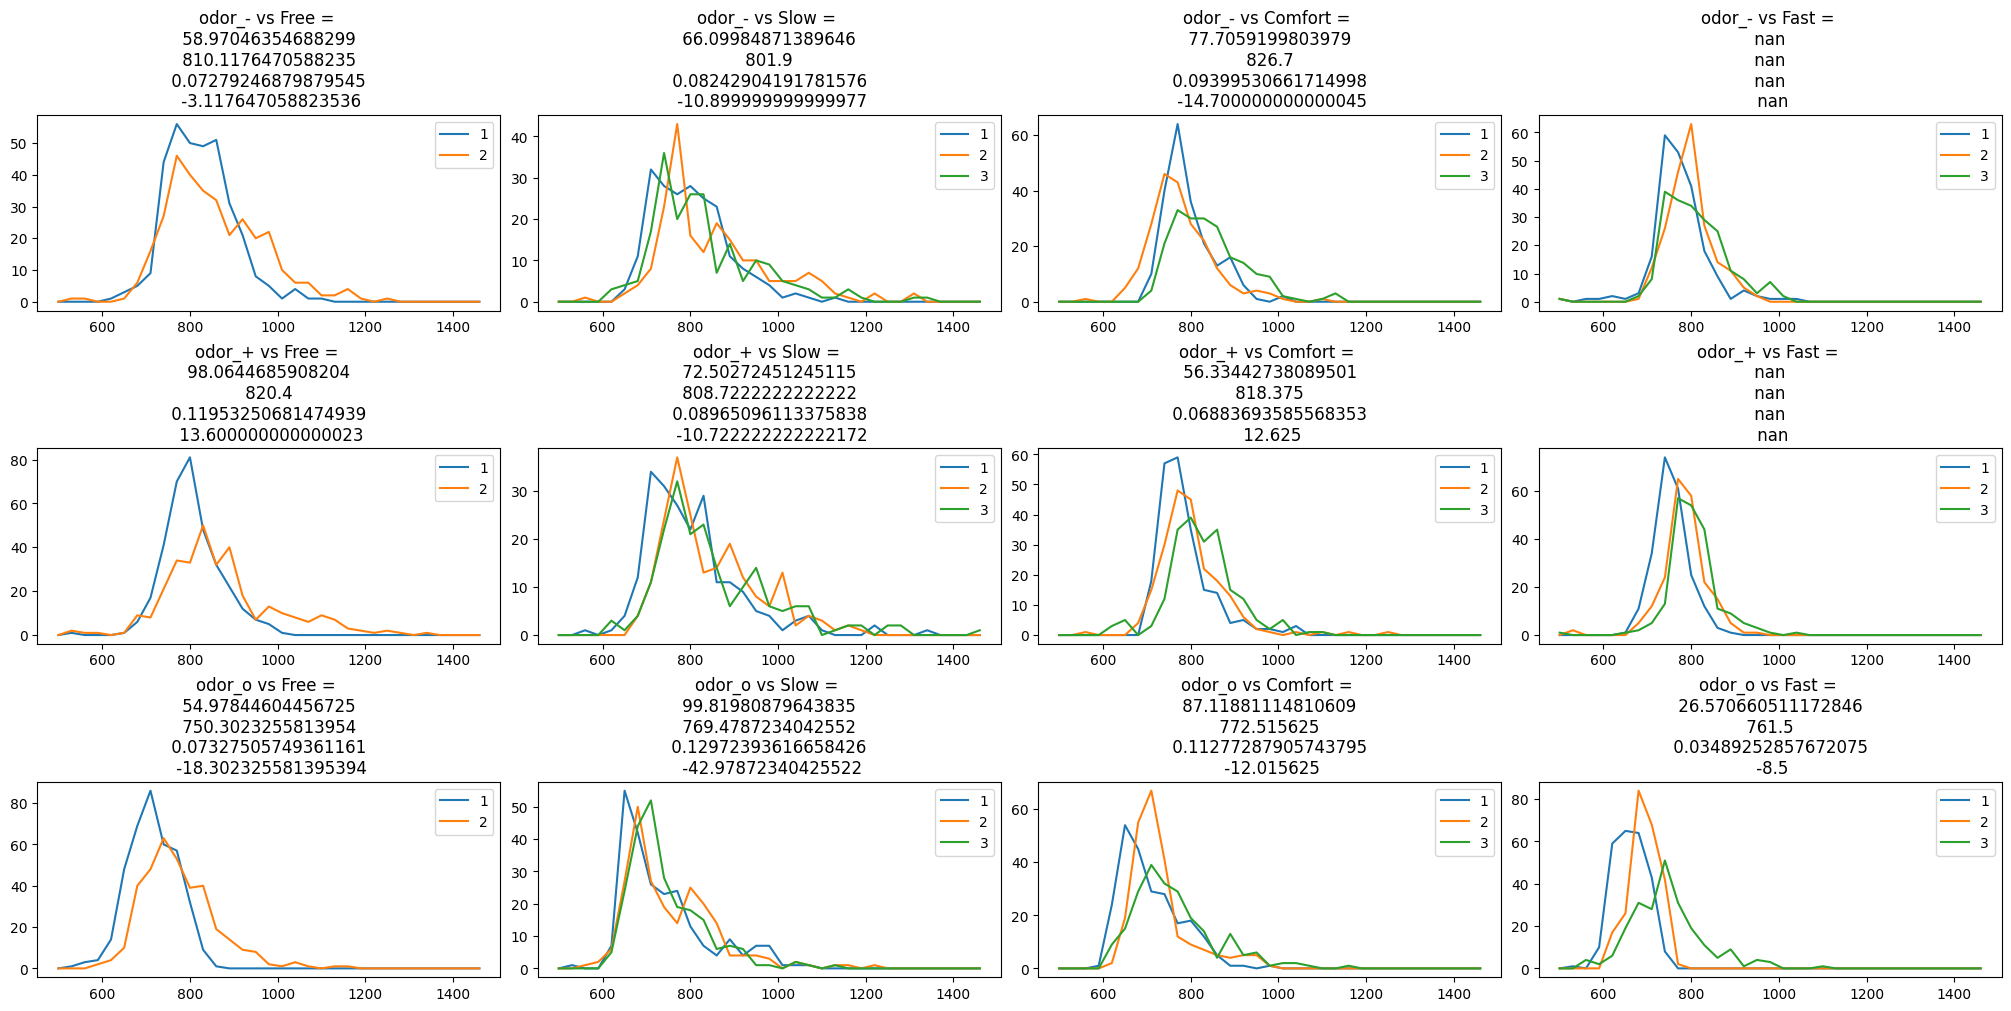

In [63]:
chan = 'ECG' 

fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (20,10), constrained_layout = True)

rows = []

for r, odor in enumerate(data.coords['odor'].values):
    for c, bloc in  enumerate(data.coords['bloc'].values):
        
        ax = axs[r,c]
        
        for trial in count_trials[bloc]:
            
            peaks = physio.detect_peak(data.loc[odor, bloc, trial, chan, :].dropna('time').values, srate)
            rris = np.diff(peaks/srate*1000.)
            metrics = physio.compute_ecg_metrics(peaks, srate, verbose = True)
            sd = metrics.loc[0,'HRV_SD']
            mu = metrics.loc[0,'HRV_Mean']
            median = metrics.loc[0,'HRV_Median']
            mad = metrics.loc[0,'HRV_Mad']
            cv = metrics.loc[0,'HRV_CV']
            mcv = metrics.loc[0,'HRV_MCV']
            asymetry = metrics.loc[0,'HRV_Asymmetry']
            rows.append([odor, bloc, trial, sd , mu ,cv, median, mad, mcv , asymetry])
            count, bins = np.histogram(rris, bins=np.arange(500, 1500., 30.))
            ax.plot(bins[:-1], count, label = trial)
        ax.legend()
        ax.set_title(f'{odor} vs {bloc} = \n {sd} \n {mu} \n {cv} \n {asymetry}')

In [65]:
df = pd.DataFrame(rows, columns = ['odor','bloc','trial','SD','MU','CV', 'median','mad','MCV','Asymmetry'])

In [66]:
df

odor     bloc  trial          SD          MU        CV  median  \
0   odor_-     Free      1    0.500000  742.500000  0.000673   742.5   
1   odor_-     Free      2   58.970464  810.117647  0.072792   807.0   
2   odor_-     Slow      1   66.672304  758.629630  0.087885   740.0   
3   odor_-     Slow      2  150.127029  848.304348  0.176973   793.0   
4   odor_-     Slow      3   66.099849  801.900000  0.082429   791.0   
5   odor_-  Comfort      1   13.500000  730.500000  0.018480   730.5   
6   odor_-  Comfort      2   35.977423  760.000000  0.047339   750.0   
7   odor_-  Comfort      3   77.705920  826.700000  0.093995   812.0   
8   odor_-     Fast      1         NaN         NaN       NaN     NaN   
9   odor_-     Fast      2         NaN         NaN       NaN     NaN   
10  odor_-     Fast      3         NaN         NaN       NaN     NaN   
11  odor_+     Free      1   32.237401  797.500000  0.040423   799.5   
12  odor_+     Free      2   98.064469  820.400000  0.119533   834.0   
13  odor_+     Slow      1  127.167902  854.578947  0.148808   832.0   
14  odor_+     Slow      2  100.769043  806.000000  0.125024   782.0   
15  odor_+     Slow      3   72.502725  808.722222  0.089651   798.0   
16  odor_+  Comfort      1   43.472650  799.115385  0.054401   787.5   
17  odor_+  Comfort      2   25.984370  766.750000  0.033889   759.5   
18  odor_+  Comfort      3   56.334427  818.375000  0.068837   831.0   
19  odor_+     Fast      1   29.673429  753.818182  0.039364   747.0   
20  odor_+     Fast      2         NaN         NaN       NaN     NaN   
21  odor_+     Fast      3         NaN         NaN       NaN     NaN   
22  odor_o     Free      1   30.548118  725.583333  0.042101   732.0   
23  odor_o     Free      2   54.978446  750.302326  0.073275   732.0   
24  odor_o     Slow      1   88.586704  749.510417  0.118193   744.0   
25  odor_o     Slow      2  108.992477  777.738095  0.140140   762.0   
26  odor_o     Slow      3   99.819809  769.478723  0.129724   726.5   
27  odor_o  Comfort      1   76.125126  714.205128  0.106587   686.0   
28  odor_o  Comfort      2   55.826204  739.318841  0.075510   734.0   
29  odor_o  Comfort      3   87.118811  772.515625  0.112773   760.5   
30  odor_o     Fast      1   14.737283  683.750000  0.021554   682.5   
31  odor_o     Fast      2   21.280493  734.875000  0.028958   738.0   
32  odor_o     Fast      3   26.570661  761.500000  0.034893   753.0   

           mad       MCV  Asymmetry  
0     0.741301  0.000998   0.000000  
1    41.512862  0.051441  -3.117647  
2    62.269293  0.084148 -18.629630  
3    25.204238  0.031783 -55.304348  
4    79.319219  0.100277 -10.900000  
5    20.015130  0.027399   0.000000  
6    36.323754  0.048432 -10.000000  
7    57.821487  0.071209 -14.700000  
8          NaN       NaN        NaN  
9          NaN       NaN        NaN  
10         NaN       NaN        NaN  
11   37.065055  0.046360   2.000000  
12   28.169442  0.033776  13.600000  
13  115.642973  0.138994 -22.578947  
14   40.030260  0.051190 -24.000000  
15   44.478067  0.055737 -10.722222  
16   32.617249  0.041419 -11.615385  
17   18.532528  0.024401  -7.250000  
18   52.632379  0.063336  12.625000  
19   40.030260  0.053588  -6.818182  
20         NaN       NaN        NaN  
21         NaN       NaN        NaN  
22   30.393345  0.041521   6.416667  
23   45.960669  0.062788 -18.302326  
24   83.025724  0.111594  -5.510417  
25  106.747360  0.140088 -15.738095  
26   57.821487  0.079589 -42.978723  
27   28.169442  0.041063 -28.205128  
28   32.617249  0.044438  -5.318841  
29   68.199702  0.089677 -12.015625  
30   22.980334  0.033671  -1.250000  
31    8.895613  0.012054   3.125000  
32   17.791227  0.023627  -8.500000

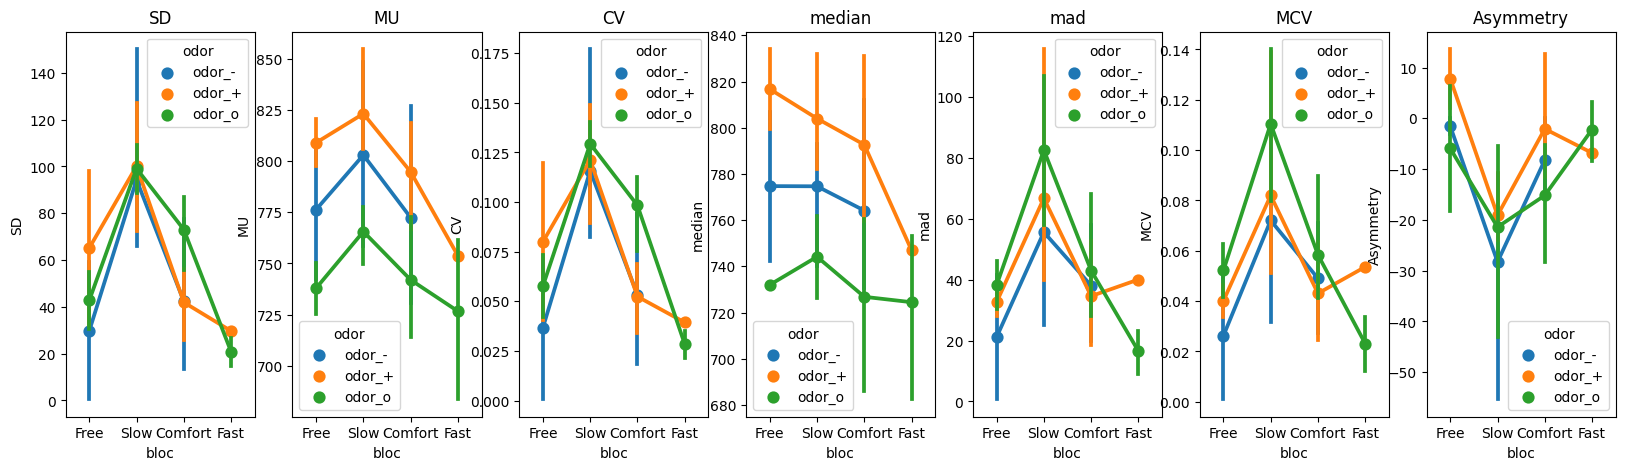

In [68]:
fig ,axs = plt.subplots(ncols = 7, figsize = (20,5))
for c, metric in enumerate(['SD','MU','CV', 'median','mad','MCV','Asymmetry']):
    ax = axs[c]
    sns.pointplot(data = df, x = 'bloc', y = metric, hue = 'odor',ax=ax)
    ax.set_title(metric)

/tmp/ipykernel_273775/4001735085.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, center = 0, cmap = 'seismic')


<AxesSubplot: >

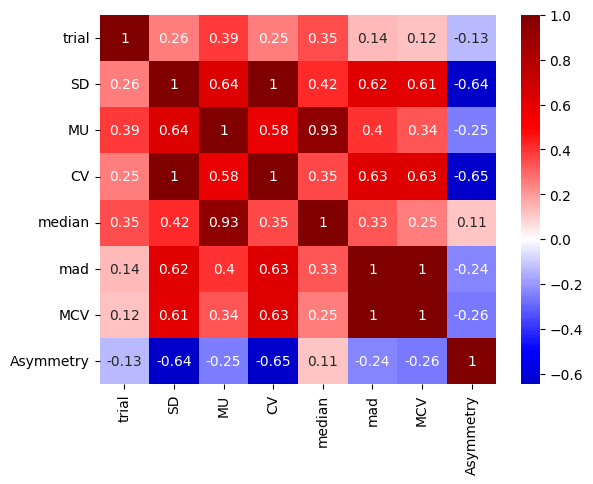

In [69]:
sns.heatmap(df.corr(), annot = True, center = 0, cmap = 'seismic')

In [70]:
metrics

HRV_Mean     HRV_SD  HRV_Median    HRV_Mad    HRV_CV   HRV_MCV  \
0     761.5  26.570661       753.0  17.791227  0.034893  0.023627   

   HRV_Asymmetry  HRV_RMSSD  
0           -8.5        1.0

In [5]:
participant = 'P01'

In [76]:
raw = mne.io.read_raw_brainvision(data_path + f'{participant}/signaux/sub{participants_label[participant]}_{session}.vhdr', verbose = 'CRITICAL')

In [79]:
get_triggs(raw, blocs, code_trigg)

timestamp
bloc    trial timing           
Free    1     start      56.223
        2     start    2402.110
        1     stop      356.221
        2     stop     2702.117
Comfort 1     start     483.201
        2     start    1127.123
        3     start    1759.957
        1     stop      663.114
        2     stop     1307.031
        3     stop     1939.876
Fast    1     start     694.093
        2     start     907.961
        3     start    1550.528
        1     stop      874.002
        2     stop     1087.874
        3     stop     1730.440
Slow    1     start    1336.493
        2     start    1982.870
        3     start    2190.619
        1     stop     1516.393
        2     stop     2162.782
        3     stop     2370.536

In [6]:
data_preproc = xr.open_dataarray(f'../Preprocessing/Data_Preprocessed/clean_{participant}_ses02.nc')

In [7]:
rsp = data_preproc.loc['RespiNasale',:].values

In [8]:
rsp

array([ 3.24765850e+01,  3.28126797e+01,  3.31495164e+01, ...,
       -3.29380809e-04, -2.77590022e-04, -2.32450174e-04])

In [11]:
rsp_features = gh.get_resp_features(rsp, srate)

In [12]:
rsp_features

start  transition     stop  start_time  transition_time  stop_time  \
0       4444        5636     8735       4.444            5.636      8.735   
1       8735        9905    13188       8.735            9.905     13.188   
2      13188       14348    16637      13.188           14.348     16.637   
3      16637       17756    21145      16.637           17.756     21.145   
4      21145       22121    24777      21.145           22.121     24.777   
..       ...         ...      ...         ...              ...        ...   
712  2959657     2960855  2964908    2959.657         2960.855   2964.908   
713  2964908     2965941  2968158    2964.908         2965.941   2968.158   
714  2968158     2970029  2977568    2968.158         2970.029   2977.568   
715  2977568     2987524  2988307    2977.568         2987.524   2988.307   
716  2988307     2990702  2992308    2988.307         2990.702   2992.308   

     cycle_duration  inspi_duration  expi_duration  cycle_freq  cycle_ratio  \
0             4.291           1.192          3.099    0.233046     0.277791   
1             4.453           1.170          3.283    0.224568     0.262744   
2             3.449           1.160          2.289    0.289939     0.336329   
3             4.508           1.119          3.389    0.221828     0.248225   
4             3.632           0.976          2.656    0.275330     0.268722   
..              ...             ...            ...         ...          ...   
712           5.251           1.198          4.053    0.190440     0.228147   
713           3.250           1.033          2.217    0.307692     0.317846   
714           9.410           1.871          7.539    0.106270     0.198831   
715          10.739           9.956          0.783    0.093119     0.927088   
716           4.001           2.395          1.606    0.249938     0.598600   

     inspi_amplitude  expi_amplitude  cycle_amplitude   inspi_volume  \
0          99.685168       59.774852       159.460020   61413.474910   
1         105.079437       51.255041       156.334478   62599.671723   
2         112.844261       84.967220       197.811481   67458.256358   
3         114.917336       82.514758       197.432094   71133.532887   
4         152.838103       61.367274       214.205377   79844.738357   
..               ...             ...              ...            ...   
712        85.264641       58.944485       144.209125   55250.590624   
713        92.310220      108.824676       201.134896   54699.095144   
714       413.793117      221.886865       635.679983  478486.144537   
715       127.250991       40.482481       167.733472  175372.928181   
716        11.618326       17.759270        29.377596   15059.077719   

       expi_volume   cycle_volume  second_volume  
0     61846.170981  123259.645891   28725.156348  
1     63486.995456  126086.667179   28314.993752  
2     72922.214791  140380.471149   40701.789258  
3     81601.585506  152735.118393   33880.904701  
4     63926.792418  143771.530776   39584.672570  
..             ...            ...            ...  
712  137545.677410  192796.268035   36716.105129  
713  119433.319877  174132.415021   53579.204622  
714  343930.254993  822416.399530   87398.129599  
715   19226.483876  194599.412057   18120.813116  
716   11262.084794   26321.162513    6578.645967  

[717 rows x 18 columns]

In [ ]:
rsp_features

In [44]:
participant = 'P13'
session  = 'ses02'

In [45]:
file1 = data_path + f'{participant}/signaux/sub{participants_label[participant]}_{session}.vhdr'
file2 = data_path + f'{participant}/signaux/sub{participants_label[participant]}_{session}_bis.vhdr'

In [46]:
raw1 = mne.io.read_raw_brainvision(file1)

Extracting parameters from /crnldata/cmo/multisite/DATA_MANIP/EEG_Lyon_VJ/Data/raw_data/P13/signaux/subRA13_ses02.vhdr...
Setting channel info structure...


/tmp/ipykernel_476673/3177818076.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw1 = mne.io.read_raw_brainvision(file1)
/tmp/ipykernel_476673/3177818076.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw1 = mne.io.read_raw_brainvision(file1)
/tmp/ipykernel_476673/3177818076.py:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw1 = mne.io.read_raw_brainvision(file1)
/tmp/ipykernel_476673/3177818076.py:1: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.


In [47]:
raw2 = mne.io.read_raw_brainvision(file2)

Extracting parameters from /crnldata/cmo/multisite/DATA_MANIP/EEG_Lyon_VJ/Data/raw_data/P13/signaux/subRA13_ses02_bis.vhdr...
Setting channel info structure...


/tmp/ipykernel_476673/3669649070.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw2 = mne.io.read_raw_brainvision(file2)
/tmp/ipykernel_476673/3669649070.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw2 = mne.io.read_raw_brainvision(file2)
/tmp/ipykernel_476673/3669649070.py:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw2 = mne.io.read_raw_brainvision(file2)
/tmp/ipykernel_476673/3669649070.py:1: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.


In [48]:
raw1

<RawBrainVision | subRA13_ses02.eeg, 35 x 1940900 (1940.9 s), ~53 kB, data not loaded>

In [49]:
raw2

<RawBrainVision | subRA13_ses02_bis.eeg, 35 x 1149660 (1149.7 s), ~53 kB, data not loaded>

In [50]:
pd.DataFrame(raw1.annotations)

onset  duration    description                        orig_time
0      0.000     0.001   New Segment/ 2022-10-14 14:58:03.857267+00:00
1      8.414     0.001  Stimulus/S 60 2022-10-14 14:58:03.857267+00:00
2      9.947     0.001  Stimulus/S 61 2022-10-14 14:58:03.857267+00:00
3    309.952     0.001  Stimulus/S 62 2022-10-14 14:58:03.857267+00:00
4    322.408     0.001  Stimulus/S 63 2022-10-14 14:58:03.857267+00:00
5    481.382     0.001  Stimulus/S100 2022-10-14 14:58:03.857267+00:00
6    486.384     0.001  Stimulus/S101 2022-10-14 14:58:03.857267+00:00
7    526.281     0.001  Stimulus/S102 2022-10-14 14:58:03.857267+00:00
8    528.687     0.001  Stimulus/S103 2022-10-14 14:58:03.857267+00:00
9    533.144     0.001  Stimulus/S104 2022-10-14 14:58:03.857267+00:00
10   543.141     0.001  Stimulus/S105 2022-10-14 14:58:03.857267+00:00
11   610.456     0.001  Stimulus/S 30 2022-10-14 14:58:03.857267+00:00
12   625.439     0.001  Stimulus/S 31 2022-10-14 14:58:03.857267+00:00
13   805.341     0.001  Stimulus/S 32 2022-10-14 14:58:03.857267+00:00
14   808.539     0.001  Stimulus/S 33 2022-10-14 14:58:03.857267+00:00
15   876.381     0.001  Stimulus/S 34 2022-10-14 14:58:03.857267+00:00
16   891.381     0.001  Stimulus/S 35 2022-10-14 14:58:03.857267+00:00
17   896.356     0.001  Stimulus/S 30 2022-10-14 14:58:03.857267+00:00
18   902.003     0.001  Stimulus/S 31 2022-10-14 14:58:03.857267+00:00
19  1081.901     0.001  Stimulus/S 32 2022-10-14 14:58:03.857267+00:00
20  1084.968     0.001  Stimulus/S 33 2022-10-14 14:58:03.857267+00:00
21  1142.889     0.001  Stimulus/S 34 2022-10-14 14:58:03.857267+00:00
22  1157.888     0.001  Stimulus/S 35 2022-10-14 14:58:03.857267+00:00
23  1166.488     0.001  Stimulus/S 50 2022-10-14 14:58:03.857267+00:00
24  1171.351     0.001  Stimulus/S 51 2022-10-14 14:58:03.857267+00:00
25  1351.272     0.001  Stimulus/S 52 2022-10-14 14:58:03.857267+00:00
26  1355.668     0.001  Stimulus/S 53 2022-10-14 14:58:03.857267+00:00
27  1409.685     0.001  Stimulus/S 54 2022-10-14 14:58:03.857267+00:00
28  1424.680     0.001  Stimulus/S 55 2022-10-14 14:58:03.857267+00:00
29  1430.660     0.001  Stimulus/S 50 2022-10-14 14:58:03.857267+00:00
30  1438.562     0.001  Stimulus/S 51 2022-10-14 14:58:03.857267+00:00
31  1618.473     0.001  Stimulus/S 52 2022-10-14 14:58:03.857267+00:00
32  1621.095     0.001  Stimulus/S 53 2022-10-14 14:58:03.857267+00:00
33  1682.601     0.001  Stimulus/S 54 2022-10-14 14:58:03.857267+00:00
34  1697.602     0.001  Stimulus/S 55 2022-10-14 14:58:03.857267+00:00
35  1707.352     0.001  Stimulus/S 50 2022-10-14 14:58:03.857267+00:00
36  1712.734     0.001  Stimulus/S 51 2022-10-14 14:58:03.857267+00:00
37  1892.648     0.001  Stimulus/S 52 2022-10-14 14:58:03.857267+00:00
38  1895.835     0.001  Stimulus/S 53 2022-10-14 14:58:03.857267+00:00

In [51]:
pd.DataFrame(raw2.annotations)

onset  duration    description                        orig_time
0      0.000     0.001   New Segment/ 2022-10-14 15:37:12.877365+00:00
1     16.348     0.001  Stimulus/S 10 2022-10-14 15:37:12.877365+00:00
2     18.933     0.001  Stimulus/S 11 2022-10-14 15:37:12.877365+00:00
3    198.840     0.001  Stimulus/S 12 2022-10-14 15:37:12.877365+00:00
4    203.559     0.001  Stimulus/S 13 2022-10-14 15:37:12.877365+00:00
5    272.225     0.001  Stimulus/S 14 2022-10-14 15:37:12.877365+00:00
6    287.235     0.001  Stimulus/S 15 2022-10-14 15:37:12.877365+00:00
7    291.744     0.001  Stimulus/S 30 2022-10-14 15:37:12.877365+00:00
8    299.951     0.001  Stimulus/S 31 2022-10-14 15:37:12.877365+00:00
9    479.864     0.001  Stimulus/S 32 2022-10-14 15:37:12.877365+00:00
10   483.059     0.001  Stimulus/S 33 2022-10-14 15:37:12.877365+00:00
11   537.709     0.001  Stimulus/S 34 2022-10-14 15:37:12.877365+00:00
12   552.709     0.001  Stimulus/S 35 2022-10-14 15:37:12.877365+00:00
13   556.948     0.001  Stimulus/S 10 2022-10-14 15:37:12.877365+00:00
14   559.891     0.001  Stimulus/S 11 2022-10-14 15:37:12.877365+00:00
15   739.799     0.001  Stimulus/S 12 2022-10-14 15:37:12.877365+00:00
16   742.623     0.001  Stimulus/S 13 2022-10-14 15:37:12.877365+00:00
17   824.945     0.001  Stimulus/S 14 2022-10-14 15:37:12.877365+00:00
18   839.938     0.001  Stimulus/S 15 2022-10-14 15:37:12.877365+00:00
19   843.104     0.001  Stimulus/S 60 2022-10-14 15:37:12.877365+00:00
20   846.264     0.001  Stimulus/S 61 2022-10-14 15:37:12.877365+00:00
21  1146.261     0.001  Stimulus/S 62 2022-10-14 15:37:12.877365+00:00

In [52]:
raw = mne.concatenate_raws([raw1 , raw2])

In [53]:
raw

<RawBrainVision | subRA13_ses02.eeg, 35 x 3090560 (3090.6 s), ~53 kB, data not loaded>

In [61]:
for i, row in pd.DataFrame(raw.annotations).iterrows():
    if list(row['description'])[-1] == '1' :
        print(row['description'], row['onset'])

Stimulus/S 61 9.947
Stimulus/S101 486.384
Stimulus/S 31 625.439
Stimulus/S 31 902.003
Stimulus/S 51 1171.351
Stimulus/S 51 1438.562
Stimulus/S 51 1712.734
Stimulus/S 11 1959.833
Stimulus/S 31 2240.851
Stimulus/S 11 2500.791
Stimulus/S 61 2787.164


In [55]:
da = mne_to_xarray(raw)

In [56]:
%matplotlib widget

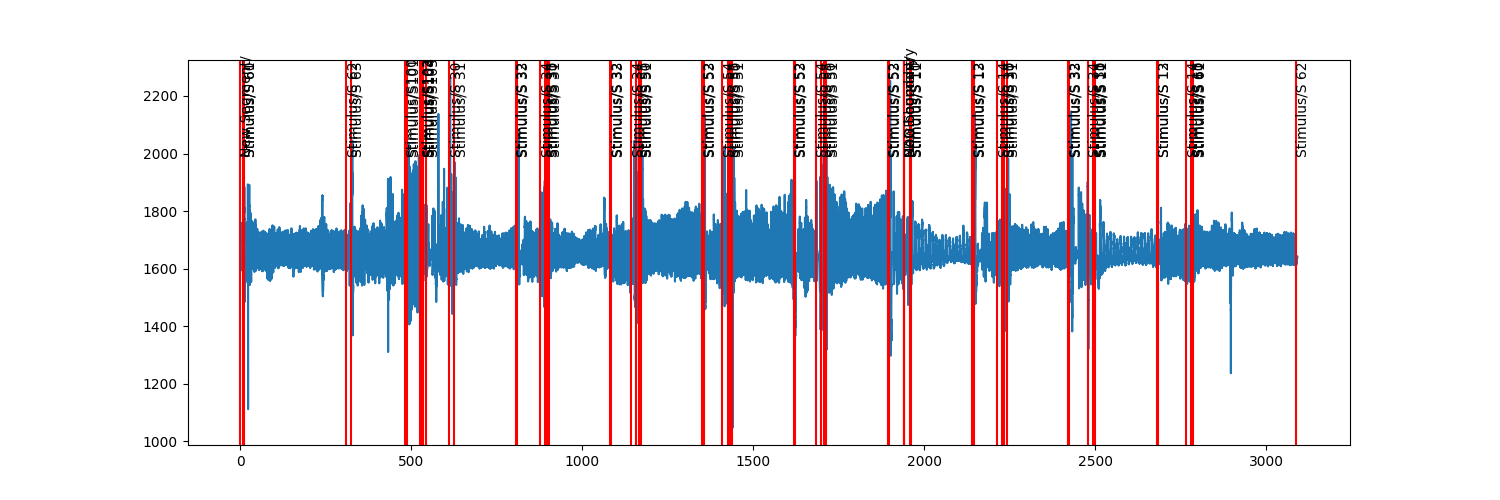

In [58]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(raw.times, da.loc['RespiNasale',:].values)

for i, row in pd.DataFrame(raw.annotations).iterrows():
    onset = row['onset']
    description = row['description']
    ax.axvline(onset, color = 'red')
    
    pos = (onset, 2000)
    ax.annotate(description , pos, rotation = 90)
plt.show()

butter iirfilter of 4th-order
btype : lowpass


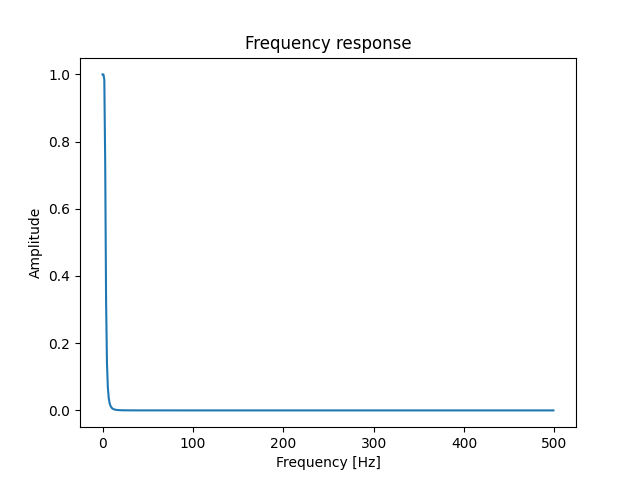

In [154]:
eda_raw = da.loc['GSR',:].values
eda_clean_moi = gh.iirfilt(eda_raw, srate, lowcut=None, highcut=3, order = 4, ftype = 'butter', show = True, verbose = True)
eda_clean_nk = nk.eda_clean(eda_raw, sampling_rate = srate)

In [155]:
%matplotlib widget

In [165]:
time = da.coords['time'].values

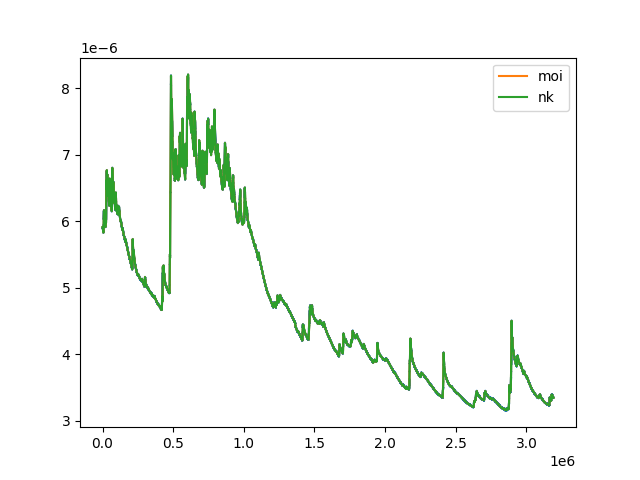

In [156]:
fig, ax = plt.subplots()
ax.plot(eda_raw)
ax.plot(eda_clean_moi, label = 'moi')
ax.plot(eda_clean_nk, label = 'nk')
ax.legend()
# ax.set_xlim(5000,10000)

In [161]:
cutoff = 0.002
ftype = 'butter'
order = 2
eda_phasic_moi = gh.iirfilt(eda_clean_nk, srate, lowcut = cutoff, highcut = None, ftype = ftype, order = order, verbose = True)
eda_tonic_moi = gh.iirfilt(eda_clean_nk, srate, lowcut = None, highcut =cutoff, ftype = ftype, order = order, verbose = True)
eda_nk = nk.eda_phasic(eda_clean_nk, sampling_rate = srate)

butter iirfilter of 2th-order
btype : highpass
butter iirfilter of 2th-order
btype : lowpass


butter iirfilter of 2th-order
btype : highpass


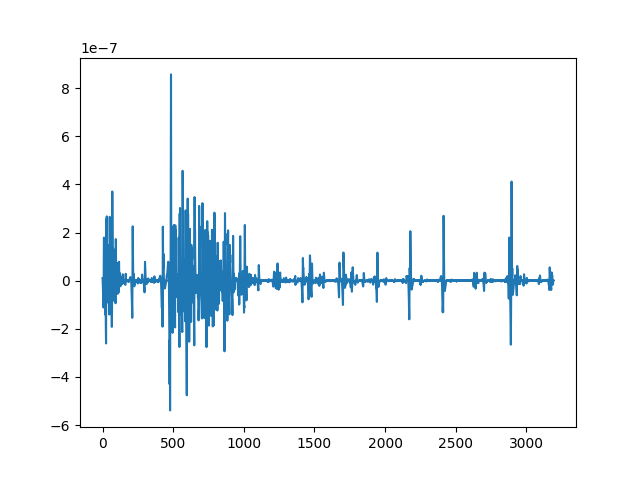

In [167]:
fig, ax = plt.subplots()
cutoff = 0.04
ftype = 'butter'
eda_phasic_moi = gh.iirfilt(eda_clean_nk, srate, lowcut = cutoff, highcut = None, ftype = ftype, order = order, verbose = True)
ax.plot(time, eda_phasic_moi)
plt.show()

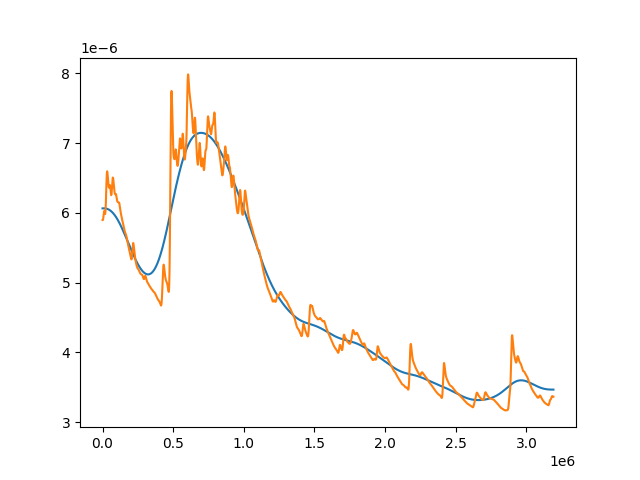

In [168]:
fig, ax = plt.subplots()
ax.plot(eda_tonic_moi)
ax.plot(eda_nk['EDA_Tonic'])
plt.show()

In [173]:
low = 0.002
f, Pxx = gh.spectre(eda_raw, srate, low)

In [188]:
freqs = [0.001 , 0.002, 0.006, 0.007, 0.01 , 0.04,  0.05 , 0.1]
for freq in freqs:
    print(freq , 1 / freq , round(1/freq / 60,1))

0.001 1000.0 16.7
0.002 500.0 8.3
0.006 166.66666666666666 2.8
0.007 142.85714285714286 2.4
0.01 100.0 1.7
0.04 25.0 0.4
0.05 20.0 0.3
0.1 10.0 0.2


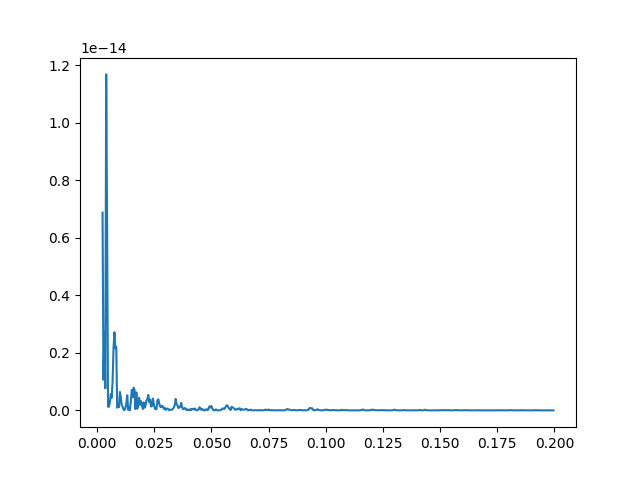

In [187]:
fig, ax = plt.subplots()
mask = (f > low) & (f < 0.2)
ax.plot(f[mask], Pxx[mask])
plt.show()

In [116]:
signals, info = nk.eda_process(eda_raw, sampling_rate=srate)

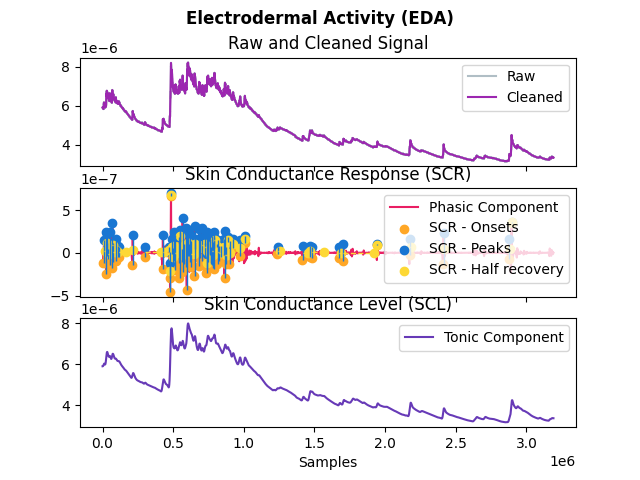

In [64]:
nk.eda_plot(signals)

In [65]:
nk.eda_analyze(signals)

SCR_Peaks_N  SCR_Peaks_Amplitude_Mean
0         76.0              2.471615e-07

In [198]:
subs = ['P01','P02','P03','P04','P05','P06','P07','P08','P09','P10','P11','P12','P13','P14','P15',
        'P16','P17','P18','P19','P20','P21','P23','P24','P25','P26','P27','P28']
sessions = ['ses02','ses03','ses04']

# da_freqs = gh.init_da({'participant':subs , 'sessions':sessions,
da_freqs = None

low = 0.002                     
for sub in subs:
    print(sub)
    for ses in sessions:         
        da = xr.open_dataarray(f'../Preprocessing/Data_Preprocessed/raw_{sub}_{ses}.nc')
        eda = da.sel(chan = 'GSR').values
        f, Pxx = gh.spectre(eda, srate, low)
        if da_freqs is None:
            da_freqs = gh.init_da({'participant':subs , 'session':sessions, 'freq':f})
        da_freqs.loc[sub, ses, :] = Pxx

P01
P02
P03
P04
P05
P06
P07
P08
P09
P10
P11
P12
P13
P14
P15
P16
P17
P18
P19
P20
P21
P23
P24
P25
P26
P27
P28


In [207]:
da_freqs

<xarray.DataArray (participant: 27, session: 3, freq: 1250001)>
array([[[6.71728330e-15, 4.92928134e-14, 9.94941637e-14, ...,
         4.08710664e-27, 4.72308115e-27, 2.76451736e-27],
        [2.19589519e-13, 4.06698313e-13, 1.82665906e-13, ...,
         5.01681094e-27, 2.59925377e-27, 6.79932132e-28],
        [3.55330716e-17, 1.26347181e-14, 7.32696606e-14, ...,
         9.71260500e-27, 1.15710884e-26, 2.90697681e-27]],

       [[7.31501541e-14, 9.46461432e-13, 1.10888348e-14, ...,
         1.37735824e-26, 2.18452641e-26, 7.08435242e-27],
        [1.21354877e-13, 3.77961938e-13, 3.19713740e-14, ...,
         7.04500339e-26, 3.08205319e-26, 2.38327135e-26],
        [8.50020298e-15, 1.24275055e-13, 2.59949894e-14, ...,
         1.63045813e-27, 2.97924107e-27, 5.89640449e-28]],

       [[3.50113809e-15, 9.04810199e-14, 2.11108891e-13, ...,
         8.27310714e-27, 1.41898072e-27, 1.60470594e-27],
        [6.57873278e-15, 2.03880827e-14, 2.79643104e-14, ...,
         2.26046287e-28, 4.45455937e-27, 4.71516590e-27],
        [8.63723487e-17, 4.57867558e-14, 7.85828524e-14, ...,
         7.51786602e-27, 3.31860240e-27, 7.91539357e-28]],
...
       [[4.24861922e-18, 4.62043084e-15, 2.16944915e-15, ...,
         5.81219555e-27, 1.52003324e-26, 3.55650791e-27],
        [6.64863960e-15, 4.74191622e-14, 3.36589624e-15, ...,
         4.50937188e-27, 1.94637198e-27, 1.44485690e-27],
        [8.78691086e-17, 5.42268779e-15, 2.51334397e-16, ...,
         3.02135738e-28, 5.57665830e-27, 9.70354484e-28]],

       [[2.82752678e-16, 4.76406083e-13, 1.83840104e-13, ...,
         2.27845426e-27, 7.28845605e-27, 9.53087735e-27],
        [6.58324632e-14, 1.59420250e-13, 3.32836252e-14, ...,
         2.41221069e-27, 3.18998122e-27, 2.26197676e-27],
        [4.68105070e-14, 2.61477028e-13, 3.29079614e-14, ...,
         5.80763869e-28, 5.17841607e-27, 5.56271660e-27]],

       [[5.11639346e-16, 8.94301018e-13, 1.47495839e-13, ...,
         1.49088472e-26, 2.46614139e-27, 5.83969963e-27],
        [5.00007654e-16, 9.14930872e-13, 1.95854868e-13, ...,
         4.56039772e-27, 6.11611921e-28, 2.18067472e-28],
        [7.16083841e-14, 2.15152825e-13, 2.06373229e-14, ...,
         2.92970857e-27, 1.26852244e-27, 1.07286014e-27]]])
Coordinates:
  * participant  (participant) <U3 'P01' 'P02' 'P03' 'P04' ... 'P26' 'P27' 'P28'
  * session      (session) <U5 'ses02' 'ses03' 'ses04'
  * freq         (freq) float64 0.0 0.0004 0.0008 0.0012 ... 500.0 500.0 500.0

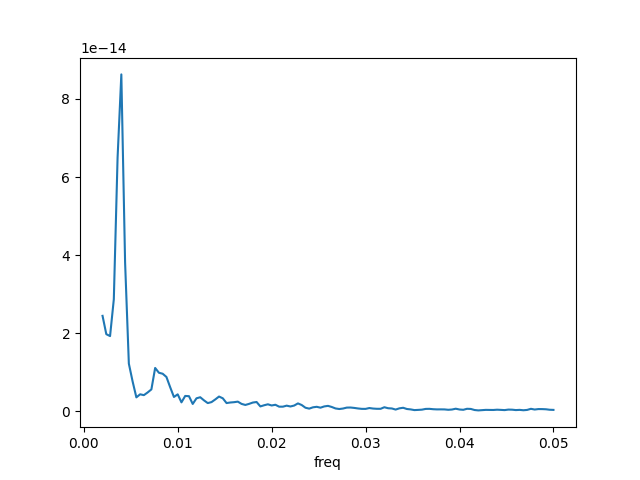

In [210]:
plt.figure()
da_freqs.mean(['participant','session']).sel(freq = slice(low, 0.05)).plot()
plt.show()

In [211]:
1 / 0.0004 / 60

41.666666666666664

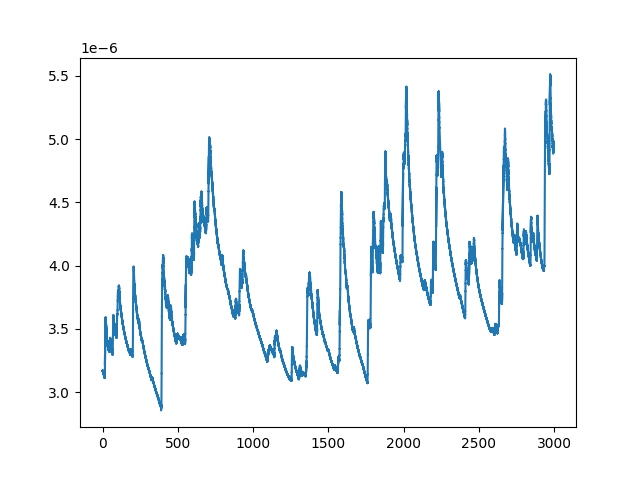

In [194]:
fig, ax=  plt.subplots()
ax.plot(time, eda)

In [199]:
da_freqs

<xarray.DataArray (participant: 27, session: 3, freq: 1250001)>
array([[[6.71728330e-15, 4.92928134e-14, 9.94941637e-14, ...,
         4.08710664e-27, 4.72308115e-27, 2.76451736e-27],
        [2.19589519e-13, 4.06698313e-13, 1.82665906e-13, ...,
         5.01681094e-27, 2.59925377e-27, 6.79932132e-28],
        [3.55330716e-17, 1.26347181e-14, 7.32696606e-14, ...,
         9.71260500e-27, 1.15710884e-26, 2.90697681e-27]],

       [[7.31501541e-14, 9.46461432e-13, 1.10888348e-14, ...,
         1.37735824e-26, 2.18452641e-26, 7.08435242e-27],
        [1.21354877e-13, 3.77961938e-13, 3.19713740e-14, ...,
         7.04500339e-26, 3.08205319e-26, 2.38327135e-26],
        [8.50020298e-15, 1.24275055e-13, 2.59949894e-14, ...,
         1.63045813e-27, 2.97924107e-27, 5.89640449e-28]],

       [[3.50113809e-15, 9.04810199e-14, 2.11108891e-13, ...,
         8.27310714e-27, 1.41898072e-27, 1.60470594e-27],
        [6.57873278e-15, 2.03880827e-14, 2.79643104e-14, ...,
         2.26046287e-28, 4.45455937e-27, 4.71516590e-27],
        [8.63723487e-17, 4.57867558e-14, 7.85828524e-14, ...,
         7.51786602e-27, 3.31860240e-27, 7.91539357e-28]],
...
       [[4.24861922e-18, 4.62043084e-15, 2.16944915e-15, ...,
         5.81219555e-27, 1.52003324e-26, 3.55650791e-27],
        [6.64863960e-15, 4.74191622e-14, 3.36589624e-15, ...,
         4.50937188e-27, 1.94637198e-27, 1.44485690e-27],
        [8.78691086e-17, 5.42268779e-15, 2.51334397e-16, ...,
         3.02135738e-28, 5.57665830e-27, 9.70354484e-28]],

       [[2.82752678e-16, 4.76406083e-13, 1.83840104e-13, ...,
         2.27845426e-27, 7.28845605e-27, 9.53087735e-27],
        [6.58324632e-14, 1.59420250e-13, 3.32836252e-14, ...,
         2.41221069e-27, 3.18998122e-27, 2.26197676e-27],
        [4.68105070e-14, 2.61477028e-13, 3.29079614e-14, ...,
         5.80763869e-28, 5.17841607e-27, 5.56271660e-27]],

       [[5.11639346e-16, 8.94301018e-13, 1.47495839e-13, ...,
         1.49088472e-26, 2.46614139e-27, 5.83969963e-27],
        [5.00007654e-16, 9.14930872e-13, 1.95854868e-13, ...,
         4.56039772e-27, 6.11611921e-28, 2.18067472e-28],
        [7.16083841e-14, 2.15152825e-13, 2.06373229e-14, ...,
         2.92970857e-27, 1.26852244e-27, 1.07286014e-27]]])
Coordinates:
  * participant  (participant) <U3 'P01' 'P02' 'P03' 'P04' ... 'P26' 'P27' 'P28'
  * session      (session) <U5 'ses02' 'ses03' 'ses04'
  * freq         (freq) float64 0.0 0.0004 0.0008 0.0012 ... 500.0 500.0 500.0

In [195]:
low = 0.002
f, Pxx = gh.spectre(eda, srate, low)

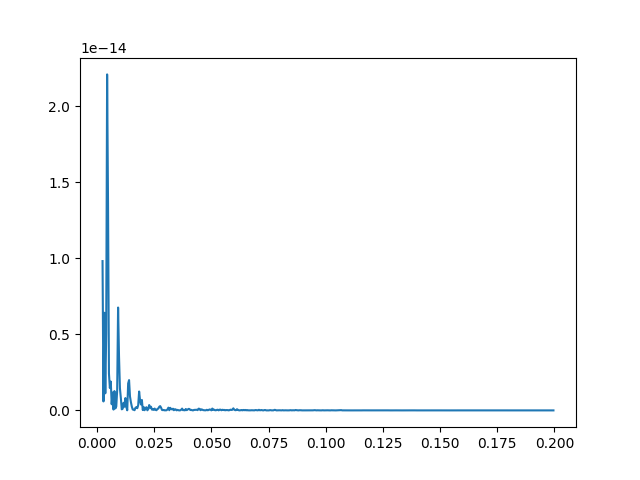

In [196]:
fig, ax = plt.subplots()
mask = (f > low) & (f < 0.2)
ax.plot(f[mask], Pxx[mask])
plt.show()

In [41]:
%matplotlib widget

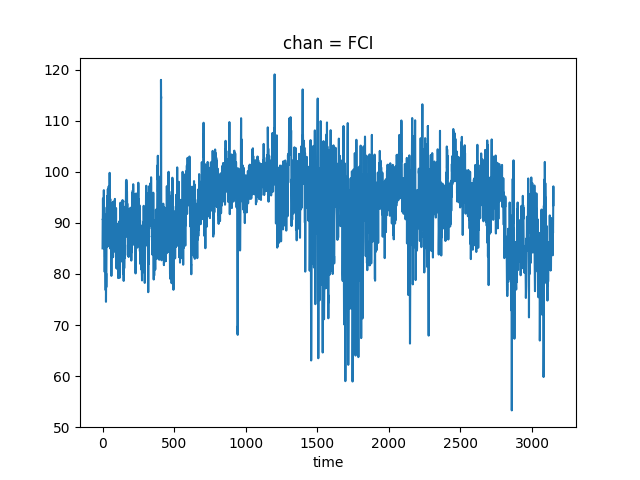

In [42]:
plt.figure()
data.loc['FCI',:].plot()
plt.show()

In [43]:
fci = data.loc['FCI',:].data

In [44]:
fci

array([85.01206832, 85.02385224, 85.03562246, ..., 93.50469476,
       93.49211728, 93.47951685])

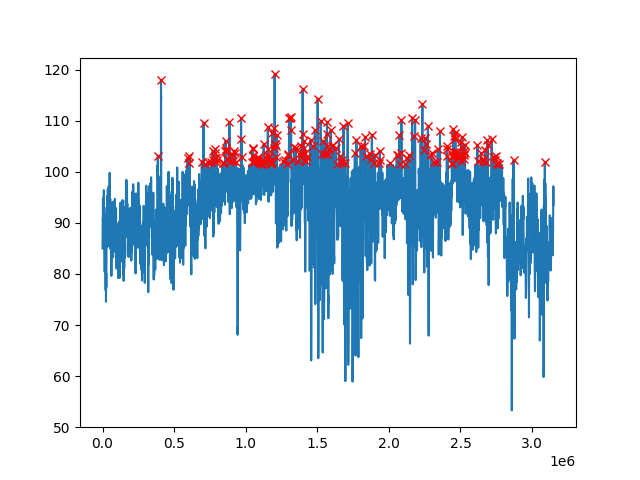

In [45]:
peaks = physio.detect_peak(fci, srate, thresh = 1, exclude_sweep_ms=1000.0)
fig, ax = plt.subplots()
ax.plot(fci)
ax.plot(peaks, fci[peaks], 'x', color ='r')
plt.show()

In [48]:
np.gradient(fci)

array([ 0.01178392,  0.01177707,  0.01176337, ..., -0.012566  ,
       -0.01258896, -0.01260044])

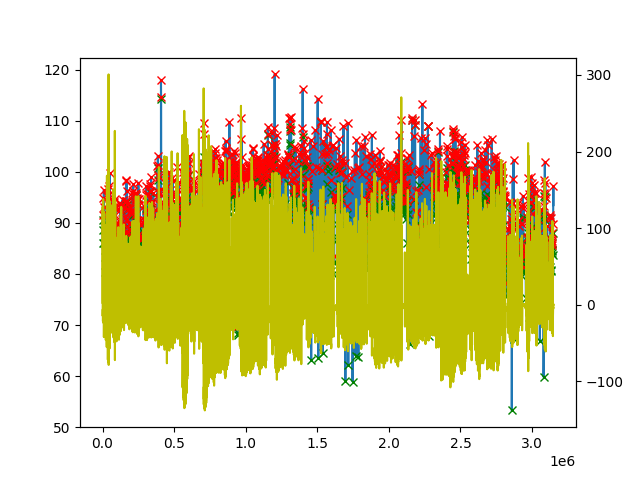

In [53]:
extremas = gh.detect_zerox(np.gradient(fci)).rename(columns = {'rises':'troughs','decays':'peaks'})
creux, pics = extremas['troughs'].values , extremas['peaks']

fig, ax = plt.subplots()
ax.plot(fci)
ax.plot(creux, fci[creux], 'x', color ='g')
ax.plot(pics, fci[pics], 'x', color ='r')
ax2 = ax.twinx()
ax2.plot(data.loc['RespiNasale',:].data, color='y')
plt.show()

In [22]:
rsas = fci[pics] - fci[creux]

In [23]:
rsas.shape

(1039,)

In [24]:
np.median(rsas)

6.1619445405923585

In [29]:
def get_rsas(fci):
    extremas = gh.detect_zerox(np.gradient(fci)).rename(columns = {'rises':'troughs','decays':'peaks'})
    creux, pics = extremas['troughs'].values , extremas['peaks']
    amplitudes_µrsa = fci[pics] - fci[creux]
    return amplitudes_rsa

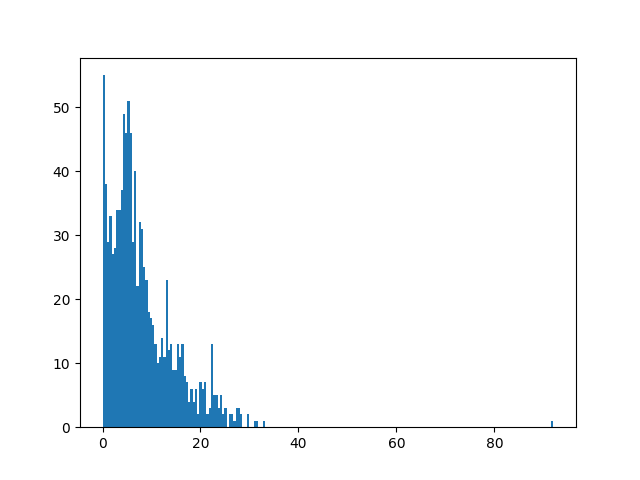

In [33]:
fig, ax = plt.subplots()
ax.hist(rsas, bins = 200)
plt.show()

In [26]:
fci

array([32.9699741 , 32.98480725, 32.9996461 , ..., 56.34023122,
       56.32808461, 56.31592868])

In [27]:
get_rsa(fci)

6.1619445405923585

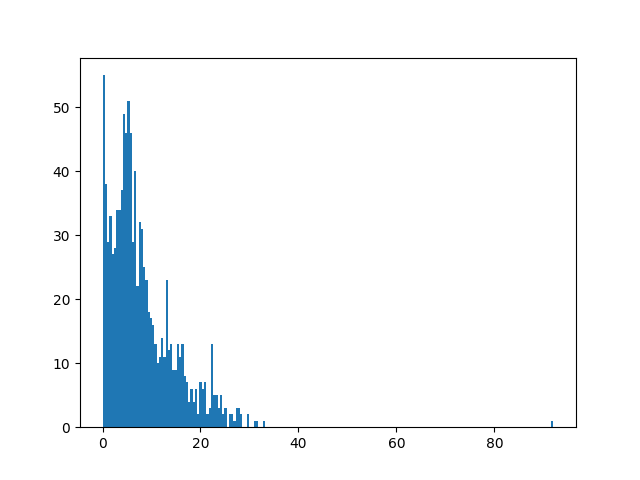

In [28]:
fig, ax = plt.subplots()
ax.hist(rsas, bins = 200)
plt.show()

In [19]:
get_rsa(fci[1220000:1390000])

6.548500797869458

In [20]:
get_rsa(fci[1500000:1680000])

5.453437609340266

In [21]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
import time

In [52]:
def sliding_mean(sig, nwin, mode = 'same'):
    """
    Sliding mean 
    
    ------
    Inputs = 
    - sig : 1D np vector
    - nwin : N samples in the sliding window
    - mode : default = 'same' = size of the output
    
    Output = 
    - smoothed_sig : signal smoothed
    """
    
    kernel = np.ones(nwin)/nwin
    smoothed_sig = signal.fftconvolve(sig, kernel , mode = mode)
    return smoothed_sig

In [50]:
t1 = time.perf_counter()
N = int(10 * srate)
smooth = sliding_mean(fci, N)
t2 = time.perf_counter()

print(t2-t1)

0.42172262188978493


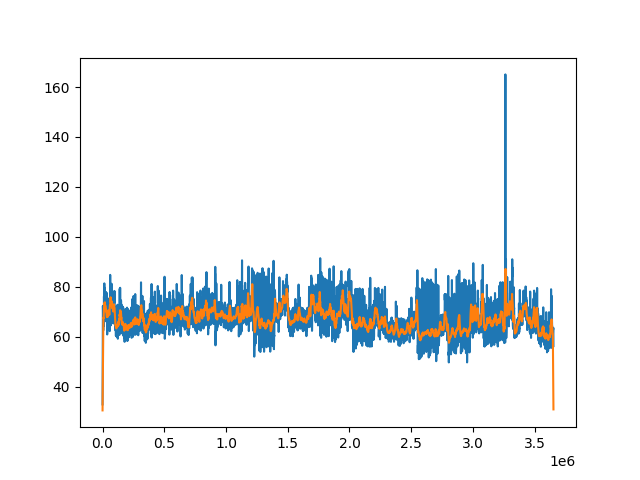

In [51]:
fig, ax = plt.subplots()
ax.plot(fci)
ax.plot(smooth)
plt.show()

In [3]:
participant = 'P01'
data_epoched = xr.open_dataarray(f'../Preprocessing/Data_Epoched/{participant}_epoched.nc')

In [4]:
data_epoched

<xarray.DataArray (odor: 3, bloc: 4, trial: 3, chan: 36, time: 300000)>
[388800000 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 300.0 300.0 300.0 300.0
  * chan     (chan) object 'Fp1' 'Fz' 'F3' 'F7' ... 'RespiVentrale' 'GSR' 'FCI'
  * bloc     (bloc) object 'Free' 'Slow' 'Comfort' 'Fast'
  * odor     (odor) object 'odor_-' 'odor_o' 'odor_+'
  * trial    (trial) int32 1 2 3

In [6]:
def compute_RSA(fci):
    """
    Compute respiratory sinus arrythmia from instantaneous cardiac frequency signal

    ----------
    Input =
    - fci : instantaneous cardiac frequency signal, ideally in beats per minute = 1D np vector

    Output =
    - median of peaks - throughs values of respiratory induced variations of the fci signal = float
    """

    derivative = np.gradient(fci) # get derivative of signal

    rises, = np.where((derivative[:-1] <=0) & (derivative[1:] >0)) # detect where sign inversion from - to +
    decays, = np.where((derivative[:-1] >=0) & (derivative[1:] <0)) # detect where sign inversion from + to -

    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay

    amplitudes_rsa = fci[decays] - fci[rises]
    return np.median(amplitudes_rsa)

In [10]:
rows = []
for participant in ['P01','P03','P04','P05','P06','P07','P08','P09','P10','P11','P12','P14','P15','P16','P17','P18','P19','P20','P21','P23','P24','P25','P26','P27','P28']:
    data_epoched = xr.open_dataarray(f'../Preprocessing/Data_Epoched/{participant}_epoched.nc')
    for odor in data_epoched.coords['odor'].values:
        for bloc in data_epoched.coords['bloc'].values:
            for trial in count_trials[bloc]:
                fci = data_epoched.loc[odor, bloc, trial, 'FCI',:].data
                med_rsa = compute_RSA(fci)
                rows.append([participant, odor, bloc, trial , med_rsa])
            

In [12]:
rsas = pd.DataFrame(rows, columns = ['participant','odor','bloc','trial','rsa'])

In [13]:
rsas

participant    odor     bloc  trial        rsa
0           P01  odor_-     Free      1   3.908177
1           P01  odor_-     Free      2   4.050029
2           P01  odor_-     Slow      1   7.852430
3           P01  odor_-     Slow      2  12.241133
4           P01  odor_-     Slow      3   5.617425
..          ...     ...      ...    ...        ...
820         P28  odor_-  Comfort      2  10.992642
821         P28  odor_-  Comfort      3   7.846499
822         P28  odor_-     Fast      1   7.111947
823         P28  odor_-     Fast      2   6.686775
824         P28  odor_-     Fast      3   8.041791

[825 rows x 5 columns]

<AxesSubplot: xlabel='bloc', ylabel='rsa'>

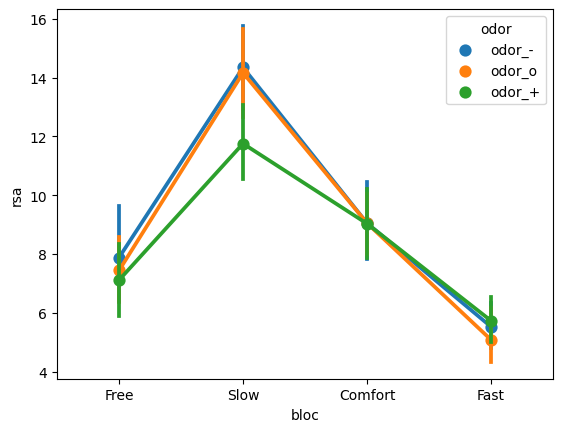

In [14]:
sns.pointplot(data = rsas , x = 'bloc', y = 'rsa', hue = 'odor')

In [12]:
participant = 'P20'

In [13]:
data = xr.open_dataarray(f'../Preprocessing/Data_Preprocessed/raw_{participant}_ses02.nc')

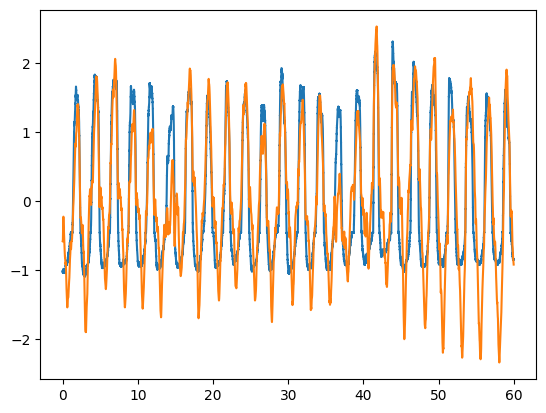

In [14]:
fig, ax = plt.subplots()
for i, chan_sel in enumerate(['RespiNasale','RespiVentrale']):
    sig = gh.norm(data.loc[ chan_sel, 1000:1060 ].values) + i
    t = np.arange(0 , sig.size / srate, 1 / srate)
    ax.plot(t, sig)
plt.show()

In [7]:
data

<xarray.DataArray (chan: 35, time: 3149260)>
[110224100 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.001 0.002 ... 3.149e+03 3.149e+03 3.149e+03
  * chan     (chan) object 'Fp1' 'Fz' 'F3' ... 'RespiNasale' 'RespiVentrale'
Attributes:
    srate:    1000.0

In [24]:
raw_resp = data.loc['RespiNasale',:].data
resp, cycles, features = physio.compute_respiration(-raw_resp, srate, baseline_mode = 'mode', sigma_ms = 100)

In [25]:
cycles

array([[    135,    1057],
       [   1592,    1669],
       [   2146,    2227],
       ...,
       [3143113, 3145093],
       [3146294, 3147813],
       [3148160,      -1]])

In [26]:
%matplotlib widget

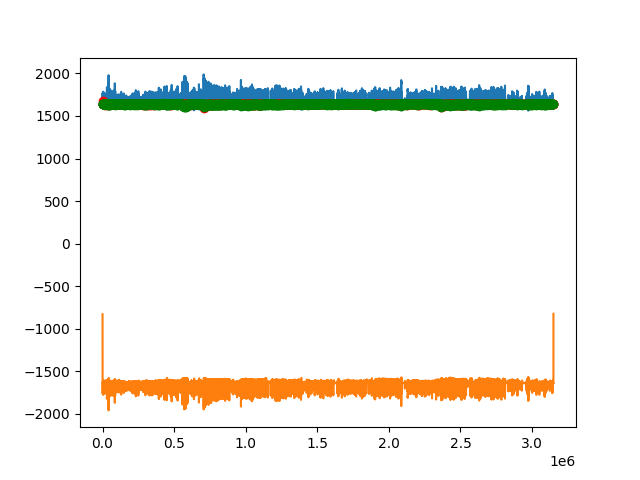

In [27]:
fig, ax = plt.subplots()
ax.plot(raw_resp)
ax.plot(cycles[:,0], raw_resp[cycles[:,0]], 'o', color = 'red')
ax.plot(cycles[:,1], raw_resp[cycles[:,1]], 'o', color = 'g')
ax.plot(resp)
plt.show()

In [72]:
resp

array([828.68862247, 838.04517255, 847.40095982, ..., 842.22793566,
       832.98939116, 823.74805191])

In [73]:
features

start  transition     stop  start_time  transition_time  stop_time  \
0        1057        1592     1669       1.057            1.592      1.669   
1        1669        2146     2227       1.669            2.146      2.227   
2        2227        3903     4978       2.227            3.903      4.978   
3        4978        7024     7316       4.978            7.024      7.316   
4        7316        7503     8599       7.316            7.503      8.599   
...       ...         ...      ...         ...              ...        ...   
1432  3137731     3138097  3139338    3137.731         3138.097   3139.338   
1433  3139338     3140407  3141784    3139.338         3140.407   3141.784   
1434  3141784     3143113  3145093    3141.784         3143.113   3145.093   
1435  3145093     3146294  3147813    3145.093         3146.294   3147.813   
1436  3147813     3148160  3149035    3147.813         3148.160   3149.035   

      cycle_duration  inspi_duration  expi_duration  cycle_freq  cycle_ratio  \
0              0.612           0.535          0.077    1.633987     0.874183   
1              0.558           0.477          0.081    1.792115     0.854839   
2              2.751           1.676          1.075    0.363504     0.609233   
3              2.338           2.046          0.292    0.427716     0.875107   
4              1.283           0.187          1.096    0.779423     0.145752   
...              ...             ...            ...         ...          ...   
1432           1.607           0.366          1.241    0.622278     0.227754   
1433           2.446           1.069          1.377    0.408831     0.437040   
1434           3.309           1.329          1.980    0.302206     0.401632   
1435           2.720           1.201          1.519    0.367647     0.441544   
1436           1.222           0.347          0.875    0.818331     0.283961   

      inspi_amplitude  expi_amplitude  cycle_amplitude  inspi_volume  \
0         1636.801585     1636.918843      3273.720428  8.721020e+05   
1         1636.750132     1636.985544      3273.735676  7.788041e+05   
2         1636.761566     1777.237104      3413.998670  2.728848e+06   
3         1636.883393     1637.106187      3273.989580  3.330734e+06   
4         1636.752995     1759.007644      3395.760639  3.043724e+05   
...               ...             ...              ...           ...   
1432      1636.753455     1688.752146      3325.505601  5.971439e+05   
1433      1636.875777     1757.790974      3394.666751  1.736460e+06   
1434      1636.784574     1743.881788      3380.666361  2.159710e+06   
1435      1636.824052     1641.747264      3278.571316  1.947533e+06   
1436      1636.749013     1644.580142      3281.329156  5.661636e+05   

       expi_volume  cycle_volume  
0     1.244015e+05  9.965035e+05  
1     1.309520e+05  9.097561e+05  
2     1.836575e+06  4.565423e+06  
3     4.763700e+05  3.807104e+06  
4     1.867217e+06  2.171589e+06  
...            ...           ...  
1432  2.054537e+06  2.651681e+06  
1433  2.314470e+06  4.050930e+06  
1434  3.306309e+06  5.466020e+06  
1435  2.486889e+06  4.434422e+06  
1436  1.432440e+06  1.998603e+06  

[1437 rows x 17 columns]

In [77]:
clean_features = features[features['cycle_freq'] < 0.5]

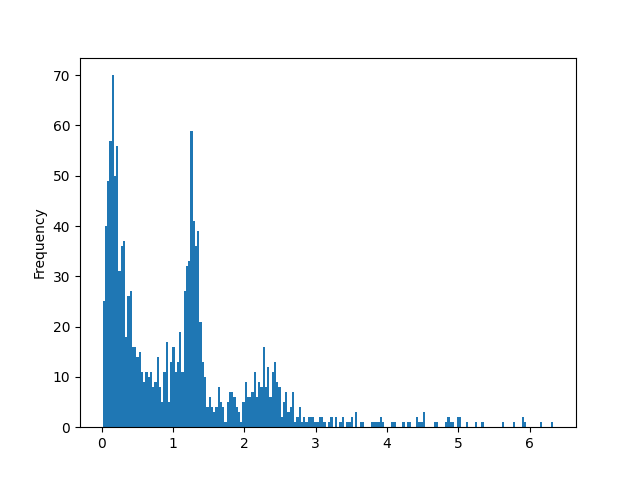

In [74]:
plt.figure()
features['inspi_duration'].plot.hist(bins = 200)
plt.show()

In [75]:
%matplotlib widget

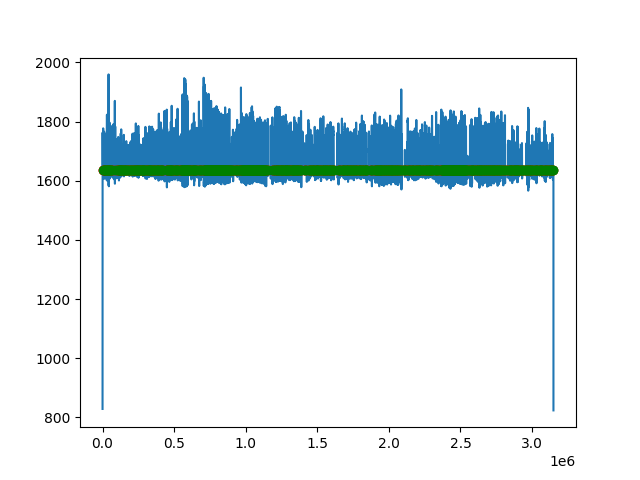

In [78]:
fig1, ax = plt.subplots()
ax.plot(resp)
ax.plot(clean_features['start'], resp[clean_features['start']], 'o', color ='r')
ax.plot(clean_features['transition'], resp[clean_features['transition']], 'o', color ='g')
plt.show()

In [8]:
participant = 'P10'
session = 'ses03'
features = pd.read_excel(base_folder / 'Tables' / 'resp_features' / f'{participant}_{session}_resp_features.xlsx', index_col = 0)

In [9]:
%matplotlib inline

<AxesSubplot: ylabel='Frequency'>

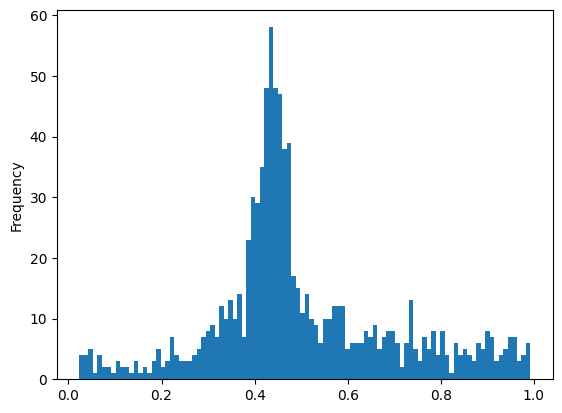

In [10]:
features['cycle_ratio'].plot.hist(bins = 100)

In [14]:
da = data

In [16]:
rows = []
f_start = 30
f_stop = 100
for chan in eeg_chans:
    sig = da.loc[chan, :].values
    f, Pxx = gh.spectre(sig, srate, 1)
    delta = np.trapz(Pxx[(f > f_start) & (f < f_stop)])
    rows.append([chan , delta])

In [17]:
delta_power = pd.DataFrame(rows, columns = ['chan','delta'])

In [18]:
# data = da.loc[eeg_chans, :].mean('time').values
data = delta_power.set_index('chan').reindex(eeg_chans)['delta']

In [19]:
pos = get_pos()
# pos = pos.reindex(da.sel(chan=eeg_chans).coords['chan'].values)
pos = pos.reindex(eeg_chans)

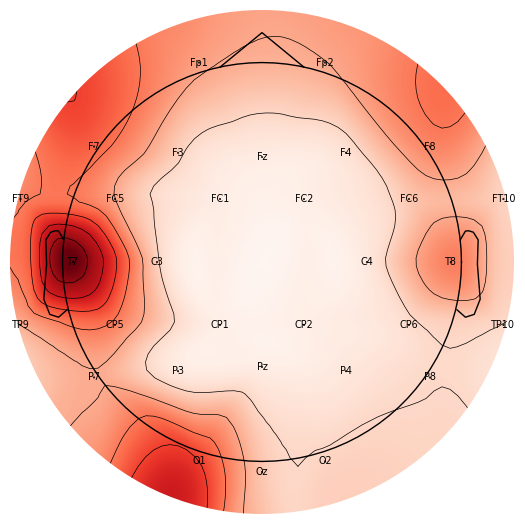

(<matplotlib.image.AxesImage at 0x7fbdb9748580>,
 <matplotlib.contour.QuadContourSet at 0x7fbdb974a8c0>)

In [20]:
fig, ax = plt.subplots(figsize = (10,6))
# mne.viz.plot_topomap(data = data, pos = raw.info , names = pos.index, axes = ax)
mne.viz.plot_topomap(data = data, pos = pos.values, names = pos.index, axes = ax, image_interp = 'cubic')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
# mne.viz.plot_topomap(data = data, pos = raw.info , names = pos.index, axes = ax)
mne.viz.plot_topomap(data = data, pos = pos.values, names = pos.index, axes = ax, image_interp = 'cubic')

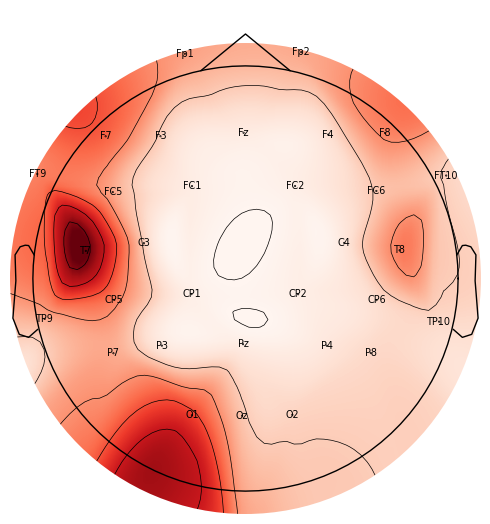

(<matplotlib.image.AxesImage at 0x7fbdb95a8c10>,
 <matplotlib.contour.QuadContourSet at 0x7fbdb95a8f70>)

In [21]:
fig, ax = plt.subplots(figsize = (10,6))
# mne.viz.plot_topomap(data = data, pos = raw.info , names = pos.index, axes = ax)
mne.viz.plot_topomap(data = data, pos = info, names = eeg_chans, axes = ax, image_interp = 'cubic')

In [4]:
ch_types = ['eeg'] * len(eeg_chans)
info = mne.create_info(eeg_chans, ch_types=ch_types, sfreq=srate)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 31 EEG
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 31
 projs: []
 sfreq: 1000.0 Hz
>

In [59]:
data = np.random.randn(10000) / 1 + 4

In [60]:
data

array([3.21841175, 4.33865458, 4.51409826, ..., 2.7852655 , 4.88105286,
       4.47770047])

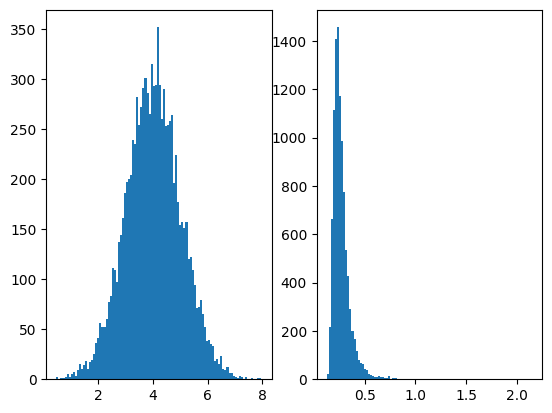

In [61]:
fig, axs = plt.subplots(ncols = 2)
bins = 100
ax = axs[0]
ax.hist(data, bins =bins)
ax = axs[1]
ax.hist(1 / data, bins = bins)
plt.show()

In [91]:
sig = data.loc['odor_o','Free',1, 'RespiNasale', :].dropna('time').values

IndexError: too many indices

In [71]:
f, Pxx_resp = gh.spectre(sig, 1000, 0.05)

In [74]:
f[np.argmax(Pxx_resp[f < 1])]

0.21

In [82]:
np.amax(Pxx_resp[f < 1])

241.5181482634601

In [79]:
Pxx_resp[f < 0.5]

array([4.08400782e-01, 2.03665982e-01, 2.40026706e+00, 5.80591274e+00,
       7.83755341e+00, 1.15959402e+01, 1.71505786e+01, 1.84268370e+01,
       2.36380812e+01, 3.50498516e+01, 3.57199690e+01, 3.92627803e+01,
       3.88076326e+01, 4.23069860e+01, 5.64939869e+01, 9.82822879e+01,
       7.92024897e+01, 1.08803353e+02, 1.58597336e+02, 1.07147026e+02,
       1.66219419e+02, 2.41518148e+02, 1.48479089e+02, 9.60145407e+01,
       1.01044789e+02, 2.09983613e+02, 1.56540986e+02, 1.08841174e+02,
       7.58374643e+01, 9.21764879e+01, 7.15492699e+01, 6.28712630e+01,
       4.50442379e+01, 7.16322058e+01, 9.74978678e+01, 5.88852721e+01,
       4.14973619e+01, 2.03430735e+01, 5.49244413e+01, 7.18045102e+01,
       3.10052098e+01, 1.39572177e+01, 2.39901071e+01, 5.15348938e+01,
       3.77225858e+01, 1.96204596e+01, 1.70285565e+01, 3.02369854e+01,
       3.38613448e+01, 4.06564748e+01])

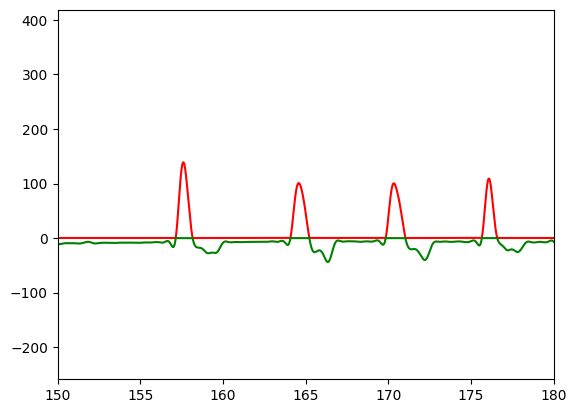

In [88]:
t = np.arange(sig.size) / 1000

fig, ax = plt.subplots()
ax.plot(t[sig > 0] , sig[sig > 0], color = 'r')
ax.plot(t[sig < 0], sig[sig < 0], color = 'g')
ax.set_xlim(150, 180)
plt.show()

In [32]:
from preproc import preproc_job, convert_vhdr_job
from store_timestamps import timestamps_job
from compute_resp_features import label_respiration_features_job
import time

In [33]:
run_key = 'P05_ses02'
ds = preproc_job.get(run_key)
da = ds['eeg_clean']

In [45]:
t_start = None
t_stop = None
factor = 2
sig = da.loc['CP6',t_start : t_stop].values
sig_down = signal.decimate(sig , factor)
time_vector = da.coords['time'].loc[t_start:t_stop].values
srate = 1000
srate_down = srate / factor
time_vector_down = np.arange(sig_down.size) / srate_down

In [46]:
time_vector[-1]

3603.959

In [47]:
time_vector_down[-1]

3603.958

In [48]:
sig_down.size

1801980

In [49]:
cycle_features = label_respiration_features_job.get(run_key).to_dataframe()
cycle_features.index.names = ['cycle']

In [50]:
cycle_features

bloc  inspi_index  expi_index  next_inspi_index  inspi_time  expi_time  \
cycle                                                                          
0                 13907       16100             19677      13.907     16.100   
1                 19677       20334             21817      19.677     20.334   
2                 21817       22691             24108      21.817     22.691   
3                 24108       25021             26519      24.108     25.021   
4                 26519       27332             31677      26.519     27.332   
...    ...          ...         ...               ...         ...        ...   
860             3587434     3588509           3590369    3587.434   3588.509   
861             3590369     3591338           3593195    3590.369   3591.338   
862             3593195     3594146           3596158    3593.195   3594.146   
863             3596158     3597068           3599184    3596.158   3597.068   
864             3599184     3600033           3602531    3599.184   3600.033   

       next_inspi_time  cycle_duration  inspi_duration  expi_duration  \
cycle                                                                   
0               19.677           5.770           2.193          3.577   
1               21.817           2.140           0.657          1.483   
2               24.108           2.291           0.874          1.417   
3               26.519           2.411           0.913          1.498   
4               31.677           5.158           0.813          4.345   
...                ...             ...             ...            ...   
860           3590.369           2.935           1.075          1.860   
861           3593.195           2.826           0.969          1.857   
862           3596.158           2.963           0.951          2.012   
863           3599.184           3.026           0.910          2.116   
864           3602.531           3.347           0.849          2.498   

       cycle_freq  cycle_ratio  inspi_volume  expi_volume  total_amplitude  \
cycle                                                                        
0        0.173310     0.380069     54.029852     9.981597       271.219648   
1        0.467290     0.307009     48.516034    44.195565       196.797098   
2        0.436491     0.381493     58.358244    96.974967       264.885392   
3        0.414766     0.378681     78.651978   102.845233       303.890685   
4        0.193874     0.157619    103.550296    86.182180       345.670973   
...           ...          ...           ...          ...              ...   
860      0.340716     0.366269     50.222349    64.412269       128.482053   
861      0.353857     0.342887     39.287603    34.669335       102.581630   
862      0.337496     0.320958     33.635579    45.179576       111.305698   
863      0.330469     0.300727     30.404624    38.612742        94.071481   
864      0.298775     0.253660     23.891751    29.109266        76.311525   

       inspi_amplitude  expi_amplitude  total_volume  
cycle                                                 
0           131.193303      140.026346     64.011448  
1           128.145646       68.651452     92.711599  
2           111.131180      153.754212    155.333211  
3           155.625038      148.265648    181.497211  
4           240.023416      105.647557    189.732476  
...                ...             ...           ...  
860          72.169923       56.312130    114.634618  
861          58.627865       43.953766     73.956938  
862          49.633758       61.671941     78.815155  
863          47.879037       46.192445     69.017366  
864          38.926523       37.385003     53.001016  

[865 rows x 18 columns]

In [51]:
cycle_features['bloc'].value_counts()

           326
Fast       211
Free       145
Comfort    133
Slow        50
Name: bloc, dtype: int64

In [52]:
ts = timestamps_job.get(run_key).to_dataframe()

In [53]:
ts = ts.set_index(['bloc','trial'])

In [54]:
masks = []
for bloc in blocs:
    for trial in ts.loc[bloc,:].index:
        t_start = ts.loc[(bloc, trial), 'timestamp']
        t_stop = t_start + ts.loc[(bloc, trial), 'duration']
        mask = (time_vector_down > t_start) & (time_vector_down < t_stop)
        masks.append(mask)

In [55]:
mask_baseline = np.any(np.array(masks), axis = 0)

In [56]:
n_freqs = 150
log_freqs = np.logspace(np.log10(4), np.log10(150), num = n_freqs, base = 10)
log_cycles = np.logspace(np.log10(10), np.log10(30), num = n_freqs, base = 10)

In [57]:
def define_morlet_family(freqs, cycles , srate, return_time = False):
    tmw = np.arange(-10,10,1/srate)
    mw_family = np.zeros((freqs.size, tmw.size), dtype = 'complex')
    for i, fi in enumerate(freqs):
        n_cycles = cycles[i]
        mw_family[i,:] = gh.complex_mw(tmw, n_cycles = n_cycles, freq = fi)
        
    if return_time:
        return tmw, mw_family
    else:
        return mw_family

In [58]:
tmw, mw_family = define_morlet_family(freqs = log_freqs , cycles = log_cycles, srate=srate_down, return_time = True)

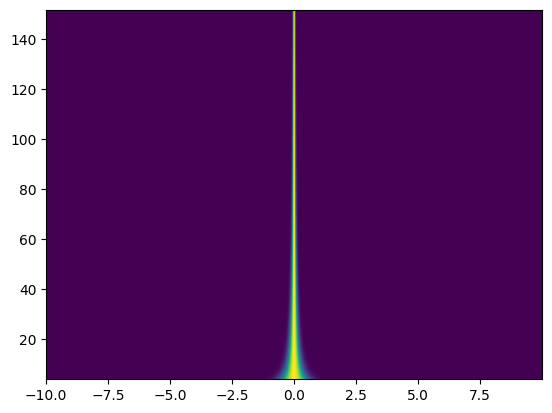

In [59]:
fig, ax = plt.subplots()
ax.pcolormesh(tmw, log_freqs, np.abs(mw_family))
plt.show()

In [60]:
amplitude_exponent = 2
sigs = np.tile(sig_down, (n_freqs,1))
t1 = time.perf_counter()
tf = signal.fftconvolve(sigs, mw_family, mode = 'same', axes = 1)
t2 = time.perf_counter()
power_log = np.abs(tf) ** amplitude_exponent
print(t2-t1)

49.72950711695012


In [61]:
axis_freq = 1
axis_time = 0

In [71]:
def mad(data, axis=0):
    return np.median(np.abs(data - np.median(data, axis = axis)), axis = axis) * 1.4826

In [169]:
def apply_baseline_normalization(power, power_baseline, mode, time_axis = 0, show_baseline = False, freqs = None):
    if mode == 'dB':
        baseline_f = np.mean(10 * np.log10(power_baseline), axis = time_axis)
        activity_tf = 10 * np.log10(power)
        power_norm = activity_tf - baseline_f
        
        # if show_baseline:
        #     fig, ax = plt.subplots()
        #     ax.plot(baseline_f)
        #     ax.set_title(mode)
        #     plt.show()
            
    elif mode == 'prct_change':
        baseline_f = np.mean(power_baseline, axis = time_axis)
        power_norm = 100 * (power - baseline_f) / baseline_f
        
        if show_baseline:
            fig, ax = plt.subplots()
            if not freqs is None:
                ax.plot(freqs, baseline_f)
            else:
                ax.plot(baseline_f)
                
            ax.set_title(mode)
            plt.show()
            
    elif mode == 'z_transform':
        baseline_f_mean = np.mean(power_baseline, axis = time_axis)
        baseline_f_std = np.std(power_baseline , axis = time_axis)
        power_norm = (power - baseline_f_mean) / baseline_f_std
        
        if show_baseline:
            
            fig, axs = plt.subplots(ncols = 2, figsize = (12,4))
            
            ax = axs[0]
            
            if not freqs is None:
                ax.plot(freqs, baseline_f_mean)
            else:
                ax.plot(baseline_f_mean)
                
            ax.set_title(f'{mode} - mean')
            
            ax = axs[1]
            if not freqs is None:
                ax.plot(freqs, baseline_f_std)
            else:
                ax.plot(baseline_f_std)
            ax.set_title(f'{mode} - std')
            
            plt.show()
            
    elif mode == 'z_transform_robust':
        med_baseline_f = np.median(power_baseline, axis = time_axis)
        mad_baseline_f = mad(power_baseline, axis = time_axis)

        power_norm = (power - med_baseline_f) / mad_baseline_f
        
        if show_baseline:
            
            fig, axs = plt.subplots(ncols = 2, figsize = (12,4))
            
            ax = axs[0]
            if not freqs is None:
                ax.plot(freqs, med_baseline_f)
            else:
                ax.plot(med_baseline_f)
            ax.set_title(f'{mode} - median')
            
            ax = axs[1]
            if not freqs is None:
                ax.plot(freqs, mad_baseline_f)
            else:
                ax.plot(mad_baseline_f)
            ax.set_title(f'{mode} - mad')
            
            plt.show()
            
    return power_norm

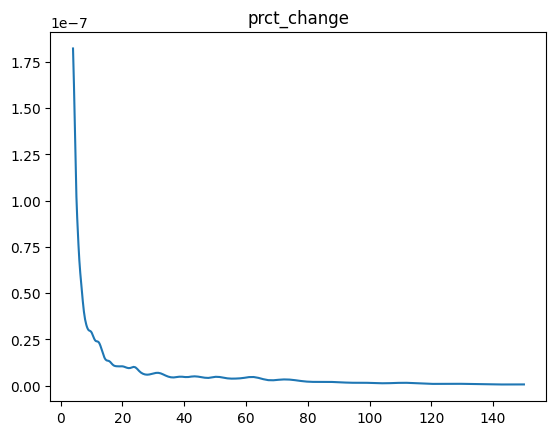

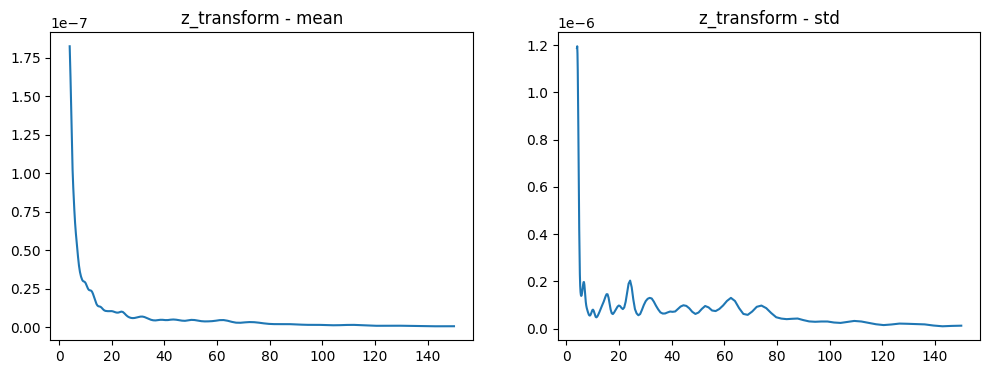

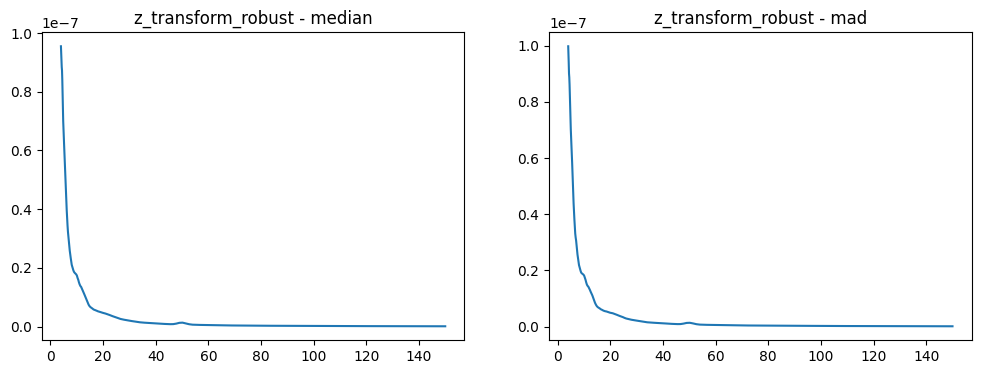

In [170]:
n_bins = 200
cycle_times = cycle_features[['inspi_time','expi_time','next_inspi_time']].values
bloc_sel = 'Slow'
q = 0.65

da_modes = None

baseline_modes = ['dB','prct_change', 'z_transform', 'z_transform_robust']
stats_modes = ['quantile','mean']

for baseline_mode in baseline_modes:
    
    power = power_log.T
    power_baseline = power_log.T[mask_baseline,:]
    
    power_log_norm = apply_baseline_normalization(power = power, power_baseline = power_baseline, mode = baseline_mode, show_baseline = True, freqs = log_freqs)
    deformed_data_stacked = physio.deform_traces_to_cycle_template(data = power_log_norm, times = time_vector_down , cycle_times=cycle_times, segment_ratios = 0.4, points_per_cycle = n_bins)
    deformed_data_stacked_bloc = deformed_data_stacked[cycle_features[cycle_features['bloc'] == bloc_sel].index,:,:]
    
    for stat_across_cycles_mode in stats_modes:
        
        if stat_across_cycles_mode == 'mean':
            deformed_data_reduced = np.mean(deformed_data_stacked_bloc, axis = 0)
        elif stat_across_cycles_mode == 'quantile':
            deformed_data_reduced = np.quantile(deformed_data_stacked_bloc, q = q, axis = 0)
            
        if da_modes is None:
            da_modes = init_nan_da({'baseline_mode':baseline_modes, 'stats_mode':stats_modes, 'freq':log_freqs , 'phase':np.linspace(0 , 1 , n_bins)})
        da_modes.loc[baseline_mode, stat_across_cycles_mode, : , :] =  deformed_data_reduced.T

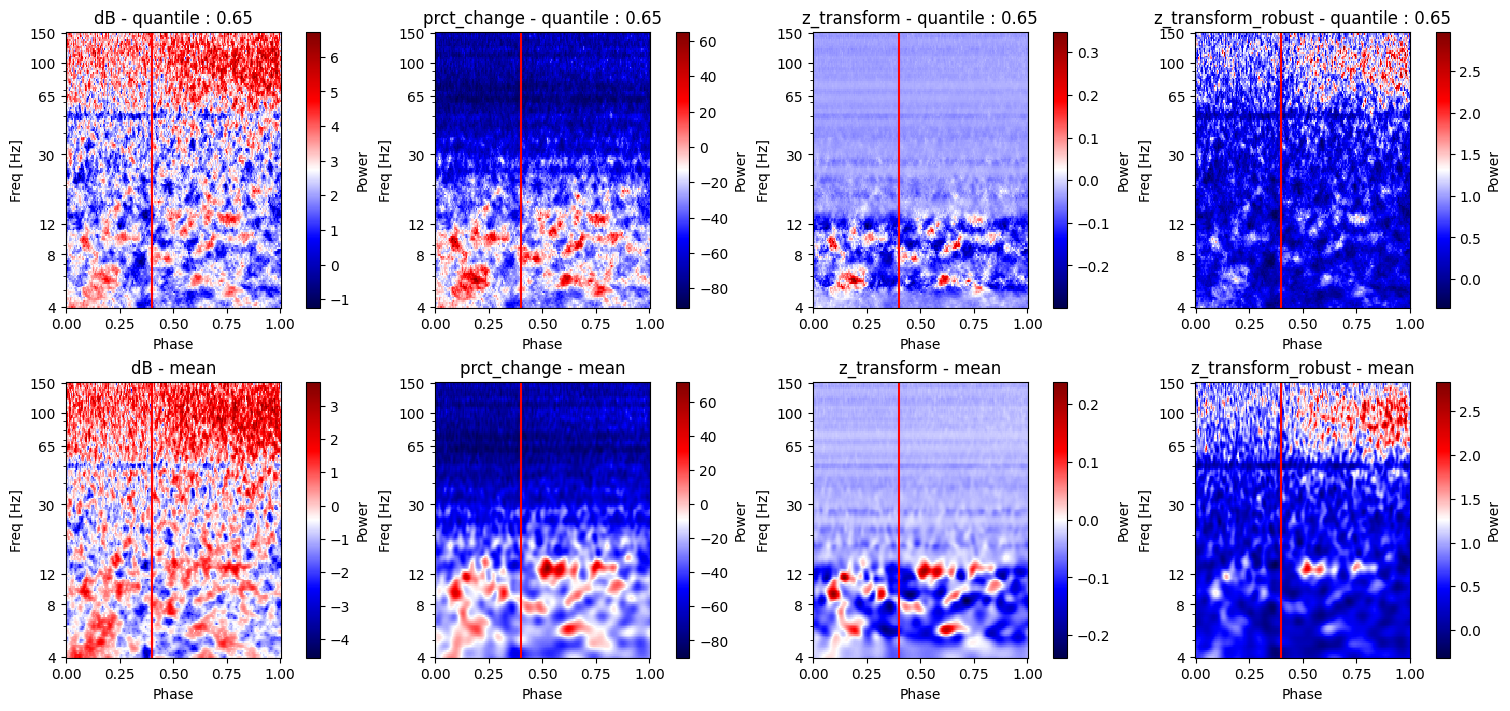

In [168]:
fig, axs = plt.subplots(nrows = len(stats_modes), ncols = len(baseline_modes), figsize = (15,7), constrained_layout = True)

for col, baseline_mode in enumerate(baseline_modes):
    for row, stat_across_cycles_mode in enumerate(stats_modes):
            
        ax = axs[row,col]
    
        im = ax.pcolormesh(da_modes.coords['phase'].values, 
                           da_modes.coords['freq'].values,  
                           da_modes.loc[baseline_mode, stat_across_cycles_mode ,:,:].values, 
                           cmap = 'seismic')
        
        clb = fig.colorbar(im, ax=ax)
        clb.set_label(f'Power')

        ax.set_yscale('log')
        ax.set_yticks([4,8,12, 30, 65, 100 , 150])
        ax.set_yticklabels([4,8,12, 30, 65, 100 , 150])
        ax.set_ylabel('Freq [Hz]')
        ax.set_xlabel('Phase')
        
        if stat_across_cycles_mode == 'quantile':
            ax.set_title(f'{baseline_mode} - {stat_across_cycles_mode} : {q}')
        elif stat_across_cycles_mode == 'mean':
            ax.set_title(f'{baseline_mode} - {stat_across_cycles_mode}')

        ax.axvline(x = 0.4, color = 'r')
        
# fig.savefig(base_folder / 'Figures'/ 'Autres' / f'phase_freq_methods_quantile_{q}.png', bbox_inches = 'tight')
        
plt.show()